### Settings

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/workspace-test1/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc
import src.helpers.oldModelUtilities as oldmodels

from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cpu


In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64

imageType = "shapes_3_dims_48_4" #10x10 triangle in 16x16 matrix shapes_3_dims_10_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7

model_directory = "model"

testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/test_images_56x56.npy')
testSample = testSample[:500]
print(testSample.shape) #Total unique images: 31 449 200

(500, 56, 56)


# Visualiation and Calculation using 2 random inputs

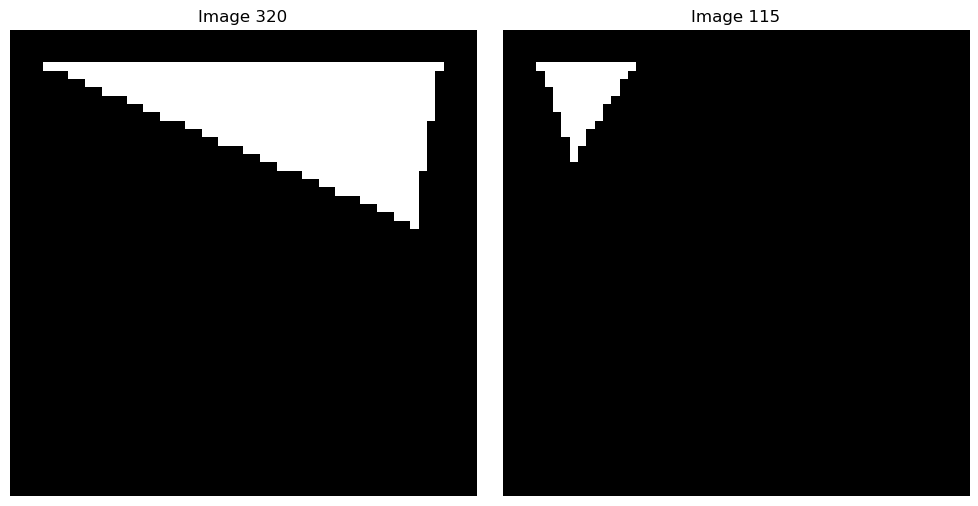

In [8]:
index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)

In [9]:
model = models.SimpleCNN6(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                                              f'best_model_{imageType}_{dimensions}d_convlayer5.pt')))
model.eval()

/tmp/ipykernel_12540/845105582.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_dir

SimpleCNN6(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size

### Visualisation of Loss score calculation -- Metric 1

In [10]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

print("\nDot product value of model embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_value = imgcalc.get_dp_score(model_transformed[index1], model_transformed[index2])

print("\nDot product value of model transformed embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

input1_transformed_normalised =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
dot_product_value = imgcalc.get_dp_score(input1_transformed_normalised, input2_transformed_normalised)

print("\nDot product value of model transformed normalised embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("\nDifference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  -0.24087470769882202

Dot product value of model embeddings:  -0.04005241021513939
Loss:  0.20082229375839233

Dot product value of model transformed embeddings:  0.15399202704429626
Loss:  0.3948667347431183

Dot product value of model transformed normalised embeddings:  0.1194886639714241
Loss:  0.3603633642196655

Dot product value of BF Method embeddings:  -0.12135920939908451
Loss:  0.11951550096273422

Difference in values of BF Method and Model Method:  0.2408478707075119


### Visualisation of KNN-IoU K score calculation -- Metric 2

----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 285: K-Score = 1.0
Intersection sets : [ 74 117 154 180 285 335 421 425]
Union sets: [ 74 117 154 180 285 335 421 425]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   285                    1.000000                            1.000000
    74                    0.500000                            0.726518
   117                    0.543033                            0.763363
   154                    0.428869                            0.677820
   180                    0.490712                            0.760653
   335                    0.444630                            0.599267
   421                    0.428869                            0.701367
   425                    0.443376                            0.688678

Comparing images in intersection & union sets

Plotting images in the intersection set:


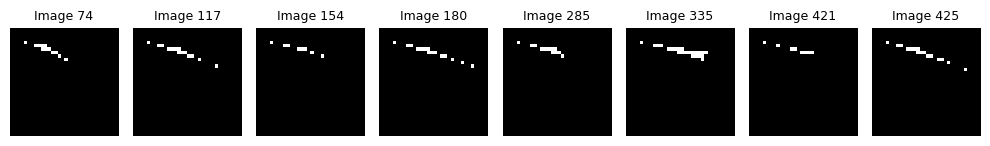


Plotting images in the union set:


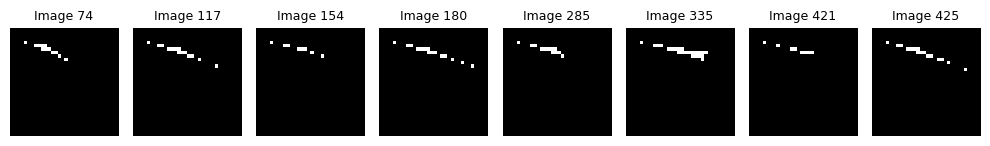


For translationally unique plots: 
Image 74 has no translationally similar images.
Image 117 has no translationally similar images.
Image 154 has no translationally similar images.
Image 180 has no translationally similar images.
Image 285 has no translationally similar images.
Image 335 has no translationally similar images.
Image 421 has no translationally similar images.
Image 425 has no translationally similar images.

Plotting images in the intersection set:


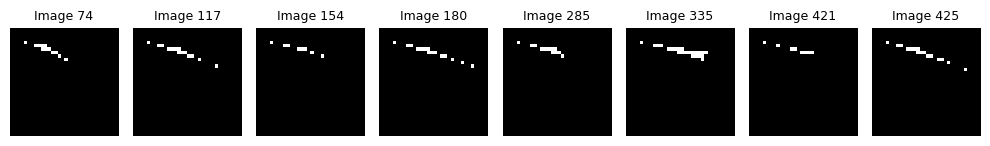


Plotting images in the union set:


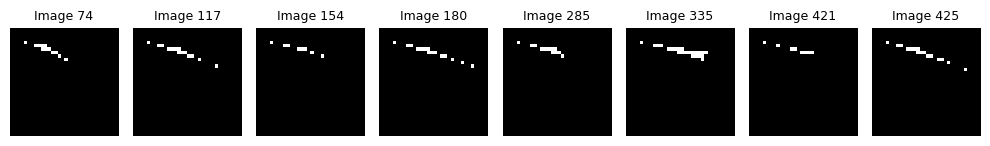


Top 16 values of Vector b
Rank 1: Value = 1.0, Index = 285
Rank 2: Value = 0.5430334806442261, Index = 117
Rank 3: Value = 0.5, Index = 74
Rank 4: Value = 0.49071204662323, Index = 180
Rank 5: Value = 0.4446300268173218, Index = 335
Rank 6: Value = 0.44337570667266846, Index = 425
Rank 7: Value = 0.4288691282272339, Index = 154
Rank 8: Value = 0.4288691282272339, Index = 421
Rank 9: Value = 0.3587324619293213, Index = 61
Rank 10: Value = 0.3587324619293213, Index = 181
Rank 11: Value = 0.35400640964508057, Index = 326
Rank 12: Value = 0.309307336807251, Index = 370
Rank 13: Value = 0.2990381717681885, Index = 35
Rank 14: Value = 0.2990381717681885, Index = 485
Rank 15: Value = 0.2990379333496094, Index = 348
Rank 16: Value = 0.2810252904891968, Index = 437

Top 16 values of Vector c
Rank 1: Value = 1.0, Index = 285
Rank 2: Value = 0.7633634341553157, Index = 117
Rank 3: Value = 0.7606530972766548, Index = 180
Rank 4: Value = 0.7265183386380296, Index = 74
Rank 5: Value = 0.70136657061

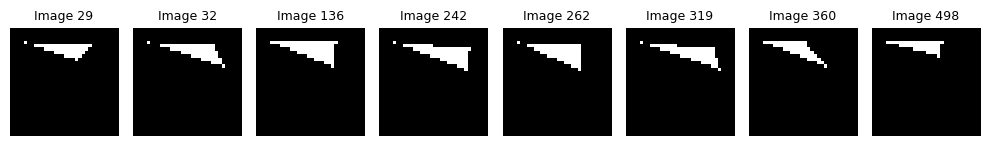


Plotting images in the union set:


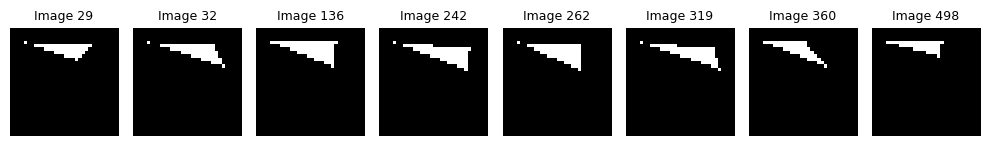


For translationally unique plots: 
Image 29 has no translationally similar images.
Image 32 has no translationally similar images.
Image 136 has no translationally similar images.
Image 242 has no translationally similar images.
Image 262 has no translationally similar images.
Image 319 has no translationally similar images.
Image 360 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


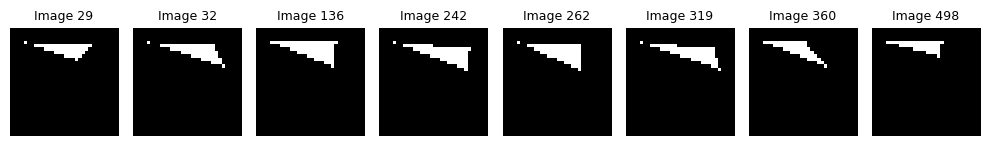


Plotting images in the union set:


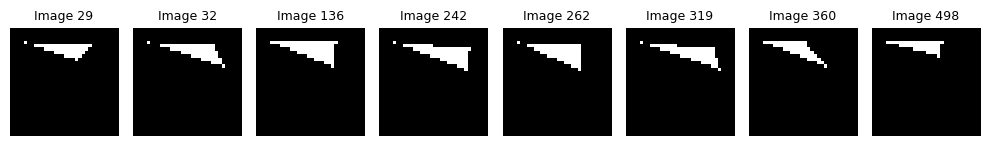


Top 16 values of Vector b
Rank 1: Value = 1.0, Index = 319
Rank 2: Value = 0.7928429841995239, Index = 242
Rank 3: Value = 0.7575503587722778, Index = 32
Rank 4: Value = 0.6701086759567261, Index = 136
Rank 5: Value = 0.6587220430374146, Index = 29
Rank 6: Value = 0.6263456344604492, Index = 360
Rank 7: Value = 0.625208854675293, Index = 262
Rank 8: Value = 0.5816093683242798, Index = 498
Rank 9: Value = 0.5600943565368652, Index = 152
Rank 10: Value = 0.5600943565368652, Index = 198
Rank 11: Value = 0.5557515621185303, Index = 355
Rank 12: Value = 0.5545631647109985, Index = 44
Rank 13: Value = 0.5506597757339478, Index = 358
Rank 14: Value = 0.5452456474304199, Index = 221
Rank 15: Value = 0.537793755531311, Index = 138
Rank 16: Value = 0.5297197103500366, Index = 86

Top 16 values of Vector c
Rank 1: Value = 1.0, Index = 319
Rank 2: Value = 0.9135318104955646, Index = 242
Rank 3: Value = 0.8801825922603488, Index = 32
Rank 4: Value = 0.7554769720595871, Index = 136
Rank 5: Value = 

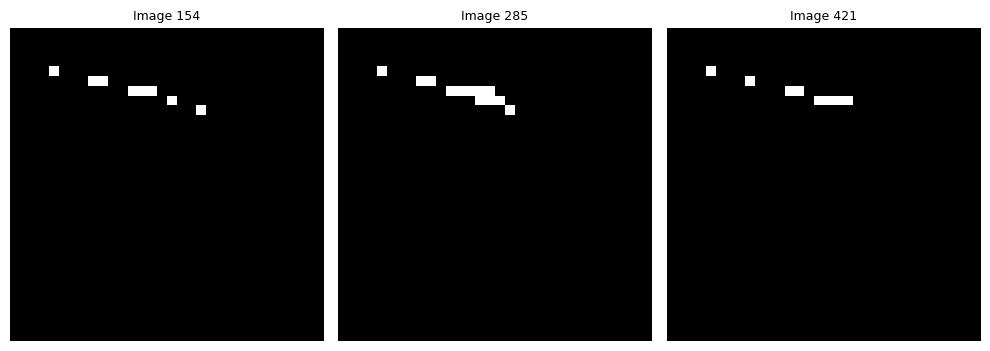


Plotting images in the union set:


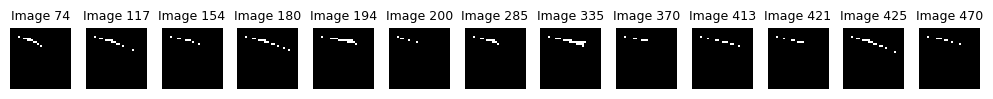


For translationally unique plots: 
Image 74 has no translationally similar images.
Image 117 has no translationally similar images.
Image 154 has no translationally similar images.
Image 180 has no translationally similar images.
Image 194 has no translationally similar images.
Image 200 has no translationally similar images.
Image 285 has no translationally similar images.
Image 335 has no translationally similar images.
Image 370 has no translationally similar images.
Image 413 has no translationally similar images.
Image 421 has no translationally similar images.
Image 425 has no translationally similar images.
Image 470 has no translationally similar images.

Plotting images in the intersection set:


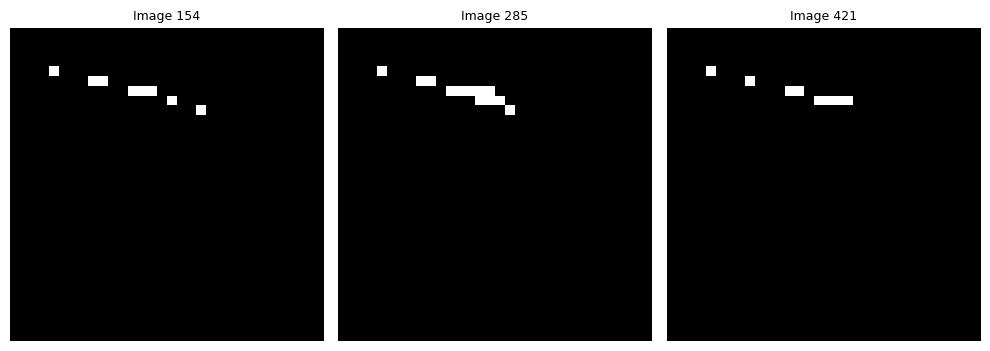


Plotting images in the union set:


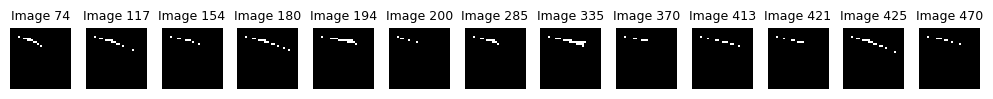

Estimating K-Score for Image 319: K-Score = 0.06666666666666667
Intersection sets : [319]
Union sets: [ 29  32  88 136 177 198 231 242 262 319 355 358 360 453 498]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   319                    1.000000                            1.000000
    29                    0.658722                            0.600510
    32                    0.757550                            0.364280
    88                    0.366984                            0.756954
   136                    0.670109                            0.491050
   177                    0.456986                            0.718305
   198                    0.560094                            0.685698
   231                    0.485531                            0.754138
   242                    0.792843                            0.589431
   262                    0.625209                            0.593093
   355       

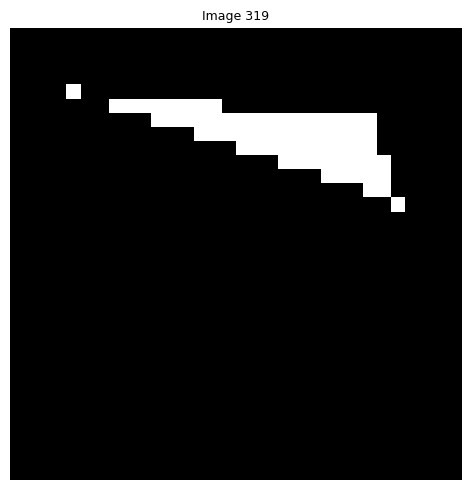


Plotting images in the union set:


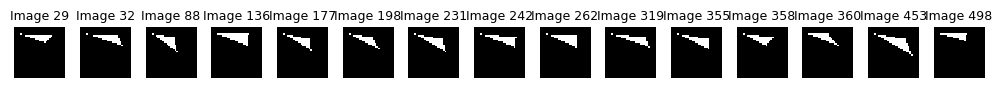


For translationally unique plots: 
Image 29 has no translationally similar images.
Image 32 has no translationally similar images.
Image 88 has no translationally similar images.
Image 136 has no translationally similar images.
Image 177 has no translationally similar images.
Image 198 has no translationally similar images.
Image 231 has no translationally similar images.
Image 242 has no translationally similar images.
Image 262 has no translationally similar images.
Image 319 has no translationally similar images.
Image 355 has no translationally similar images.
Image 358 has no translationally similar images.
Image 360 has no translationally similar images.
Image 453 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


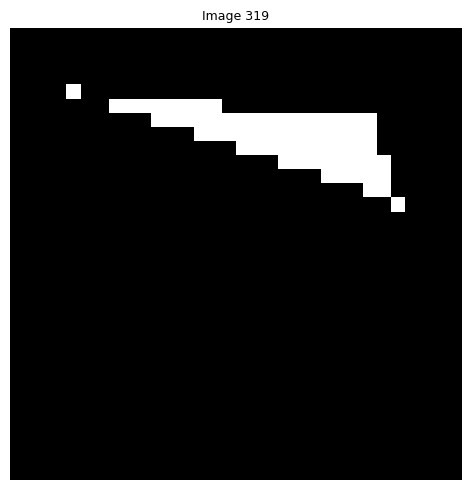


Plotting images in the union set:


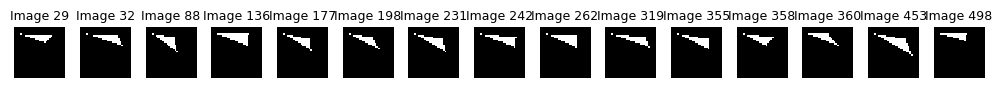

----------------
Transformed Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 285: K-Score = 0.0
Intersection sets : []
Union sets: [  8  74 117 154 177 180 231 285 321 335 348 392 421 425 441 453]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   285                    1.000000                            0.659741
     8                   -0.460640                            0.818362
    74                    0.500000                            0.193327
   117                    0.543033                           -0.016639
   154                    0.428869                           -0.030807
   177                   -0.082337                            1.151533
   180                    0.490712                            0.737091
   231                   -0.159832                            1.142241
   321                   -0.112934                            1.215214
   335                 

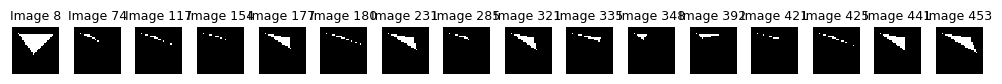


For translationally unique plots: 
Image 8 has no translationally similar images.
Image 74 has no translationally similar images.
Image 117 has no translationally similar images.
Image 154 has no translationally similar images.
Image 177 has no translationally similar images.
Image 180 has no translationally similar images.
Image 231 has no translationally similar images.
Image 285 has no translationally similar images.
Image 321 has no translationally similar images.
Image 335 has no translationally similar images.
Image 348 has no translationally similar images.
Image 392 has no translationally similar images.
Image 421 has no translationally similar images.
Image 425 has no translationally similar images.
Image 441 has no translationally similar images.
Image 453 has no translationally similar images.

No images in the intersection set to display.

Plotting images in the union set:


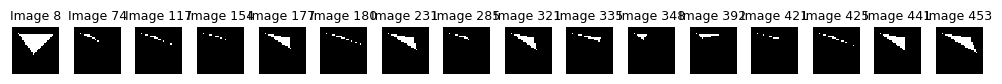

Estimating K-Score for Image 319: K-Score = 0.14285714285714285
Intersection sets : [242 319]
Union sets: [ 29  32 136 180 184 231 242 250 262 319 355 360 453 498]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   319                    1.000000                            0.340577
    29                    0.658722                            0.041324
    32                    0.757550                            0.182280
   136                    0.670109                            0.195032
   180                   -0.096304                            0.254551
   184                    0.094701                            0.263556
   231                    0.485531                            0.254698
   242                    0.792843                            0.330896
   250                    0.505301                            0.280789
   262                    0.625209                            0.140517
   355       

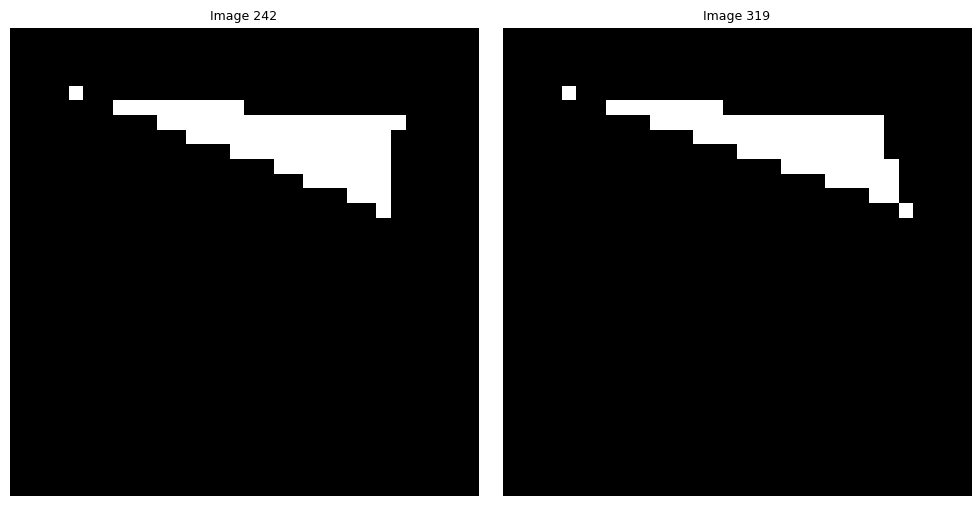


Plotting images in the union set:


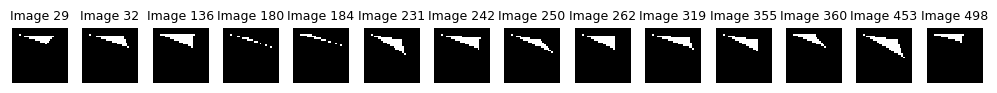


For translationally unique plots: 
Image 29 has no translationally similar images.
Image 32 has no translationally similar images.
Image 136 has no translationally similar images.
Image 180 has no translationally similar images.
Image 184 has no translationally similar images.
Image 231 has no translationally similar images.
Image 242 has no translationally similar images.
Image 250 has no translationally similar images.
Image 262 has no translationally similar images.
Image 319 has no translationally similar images.
Image 355 has no translationally similar images.
Image 360 has no translationally similar images.
Image 453 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


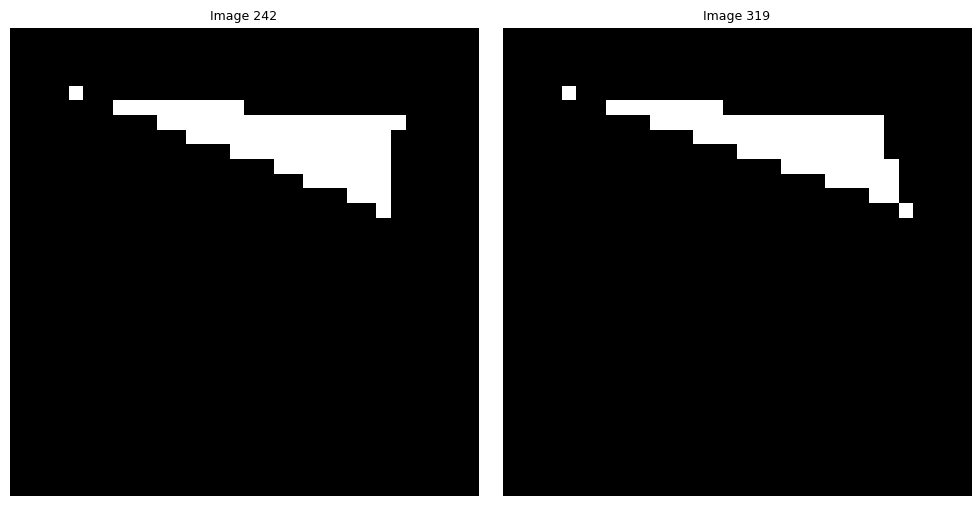


Plotting images in the union set:


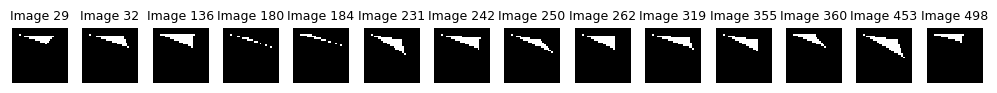

----------------
Transformed Normalised Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 285: K-Score = 0.23076923076923078
Intersection sets : [180 285 335]
Union sets: [ 74 117 154 177 180 252 285 324 335 348 392 421 425]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   285                    1.000000                            1.000000
    74                    0.500000                            0.307168
   117                    0.543033                           -0.027250
   154                    0.428869                           -0.050478
   177                   -0.082337                            0.668079
   180                    0.490712                            0.764602
   252                   -0.186857                            0.709039
   324                    0.016950                            0.675316
   335                    0.444630                            0.7184

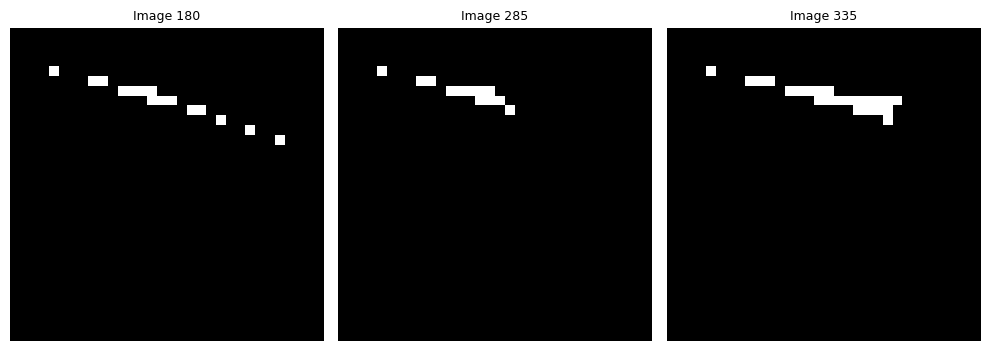


Plotting images in the union set:


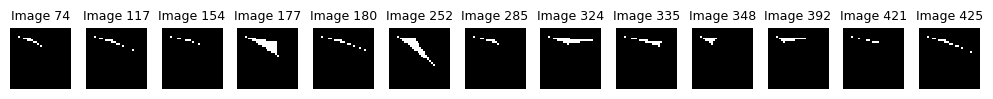


For translationally unique plots: 
Image 74 has no translationally similar images.
Image 117 has no translationally similar images.
Image 154 has no translationally similar images.
Image 177 has no translationally similar images.
Image 180 has no translationally similar images.
Image 252 has no translationally similar images.
Image 285 has no translationally similar images.
Image 324 has no translationally similar images.
Image 335 has no translationally similar images.
Image 348 has no translationally similar images.
Image 392 has no translationally similar images.
Image 421 has no translationally similar images.
Image 425 has no translationally similar images.

Plotting images in the intersection set:


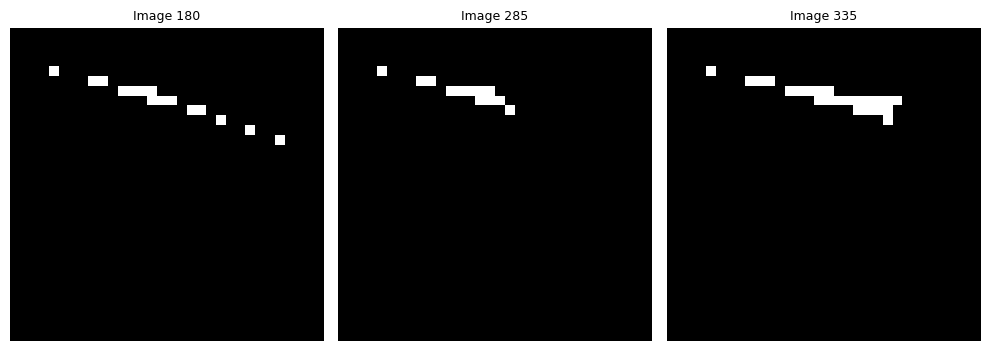


Plotting images in the union set:


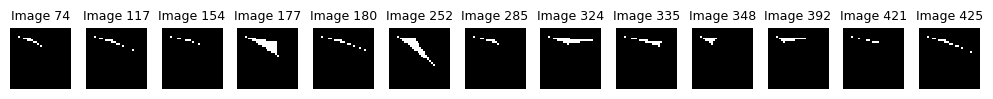

Estimating K-Score for Image 319: K-Score = 0.23076923076923078
Intersection sets : [ 32 242 319]
Union sets: [ 29  32 136 155 228 242 250 262 319 344 360 425 498]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   319                    1.000000                            1.000000
    29                    0.658722                            0.095086
    32                    0.757550                            0.596899
   136                    0.670109                            0.461494
   155                    0.392128                            0.477612
   228                    0.154701                            0.496286
   242                    0.792843                            0.739787
   250                    0.505301                            0.463982
   262                    0.625209                            0.261756
   344                    0.422070                            0.468655
   360       

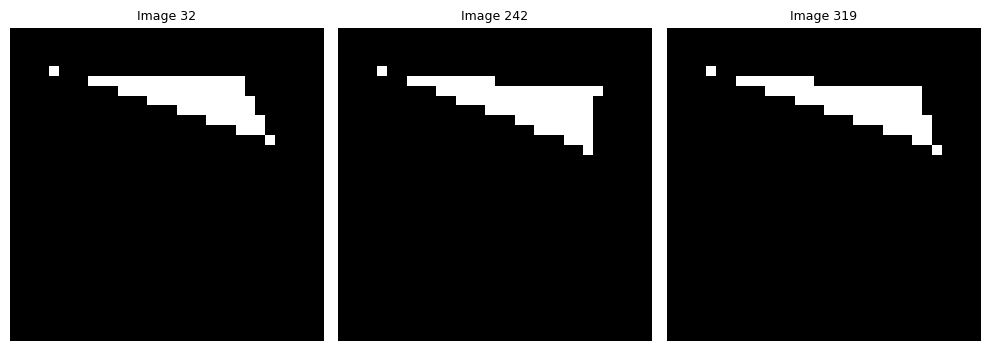


Plotting images in the union set:


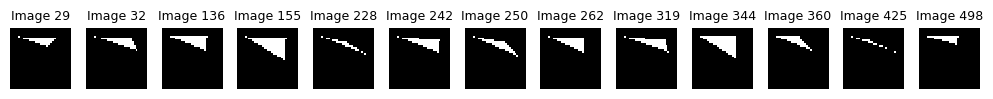


For translationally unique plots: 
Image 29 has no translationally similar images.
Image 32 has no translationally similar images.
Image 136 has no translationally similar images.
Image 155 has no translationally similar images.
Image 228 has no translationally similar images.
Image 242 has no translationally similar images.
Image 250 has no translationally similar images.
Image 262 has no translationally similar images.
Image 319 has no translationally similar images.
Image 344 has no translationally similar images.
Image 360 has no translationally similar images.
Image 425 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


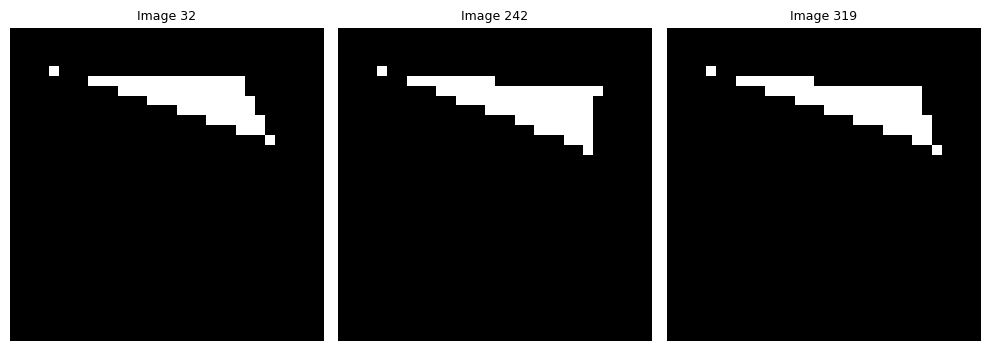


Plotting images in the union set:


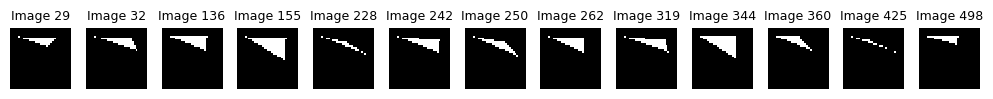

(array([ 32, 242, 319]),
 [29, 32, 136, 155, 228, 242, 250, 262, 319, 344, 360, 425, 498])

In [7]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)

print("----------------\nTransformed Model Method -- KNN-IOU score\n----------------")
input2_transformed_1 =  model_transformed[index1]
input2_transformed_2 =  model_transformed[index2]
vectorc_transformed_1 = []
vectorc_transformed_2 = []
for j in range(len(input_dataset)):
    input1_transformed =  model_transformed[j]
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_1, dim=1)
    vectorc_transformed_1.append(dot_product_transformed.detach().cpu().numpy().item())
    
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_2, dim=1)
    vectorc_transformed_2.append(dot_product_transformed.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_2, "Model", index2, k, testSample)

print("----------------\nTransformed Normalised Model Method -- KNN-IOU score\n----------------")
input2_transformed_normalised_1 =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised_2 =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
vectorc_transformed_normalised_1 = []
vectorc_transformed_normalised_2 = []
for j in range(len(input_dataset)):
    input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_1, dim=1)
    vectorc_transformed_normalised_1.append(dot_product_transformed_normalised.detach().cpu().numpy().item())
    
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_2, dim=1)
    vectorc_transformed_normalised_2.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_normalised_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_normalised_2, "Model", index2, k, testSample)

### Visualisation of Relative Squared Difference of **original** matrix and vector embedding -- Metric 3

In [ ]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Matrices -- Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of of Matrices -- Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of of Matrices -- Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed** matrix and vector embedding using Orthogonal Procrustes -- Metric 3

In [7]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Matrices -- Transformed Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Matrices -- Transformed Model and Pencorr (A'A):", mean_squared_difference)

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Transformed Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

Difference between matrices

Mean Squared Difference of Model and NCC (G): 1.5068431908935553
Mean Squared Difference of Model and Pencorr (A'A): 1.447351941599006
Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.3230924922125886

Printing matrices after transformation

Matrix G: [[ 1.         -0.65184468 -0.47018713 ... -0.75520396 -0.64365166
  -0.61025807]
 [-0.65184468  1.         -0.30828559 ... -0.16903645  0.2561537
   0.15337098]
 [-0.47018713 -0.30828559  1.         ... -0.51363957  0.27438617
  -0.53539678]
 ...
 [-0.75520396 -0.16903645 -0.51363957 ...  1.         -0.08405721
  -0.09363103]
 [-0.64365166  0.2561537   0.27438617 ... -0.08405721  1.
  -0.13197589]
 [-0.61025807  0.15337098 -0.53539678 ... -0.09363103 -0.13197589
   1.        ]]

Matrix A'A (Pencorr): [[ 1.         -0.40385153  0.17631002 ... -0.42973586 -0.42813806
  -0.22991002]
 [-0.40385153  1.         -0.15187719 ... -0.10746696  0.31210782
   0.22254778]
 [ 0.17631002 -0.15187719  1.         ... -0

ValueError: operands could not be broadcast together with shapes (500,) (64,) 

### Visualisation of Relative Squared Difference of **transformed normalised** vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After normalising the transformed output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Normalised Model: {model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy()))
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Normalised Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of original vector embeddings of similar images across dimensions -- Metric 4

For dimension 32
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


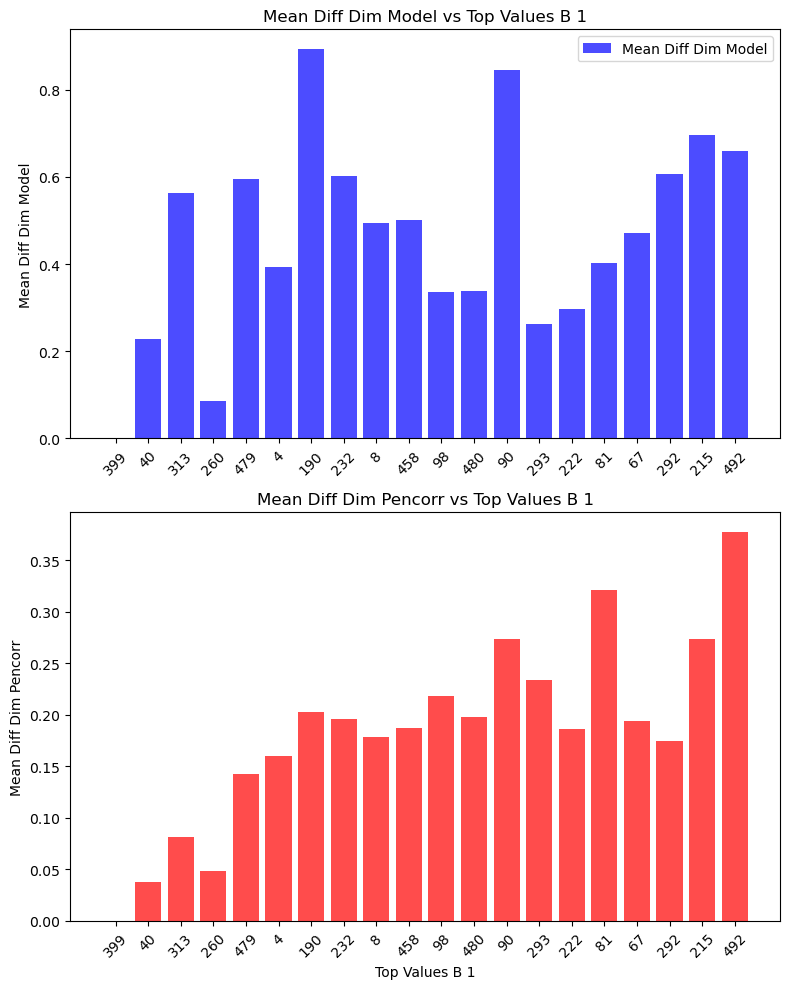

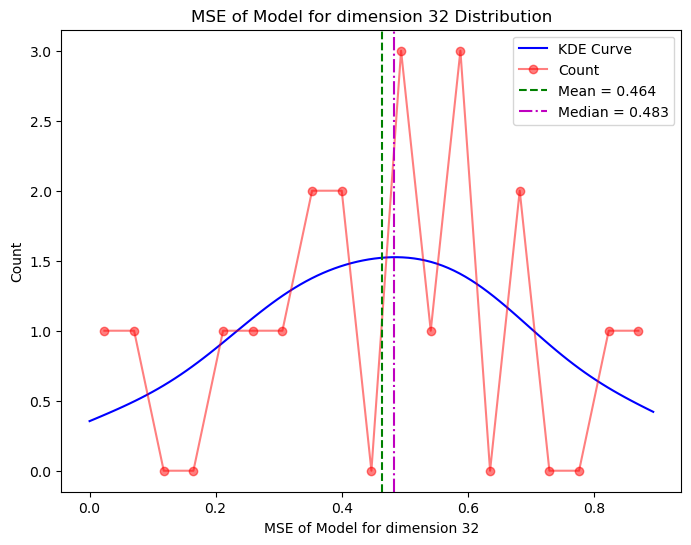

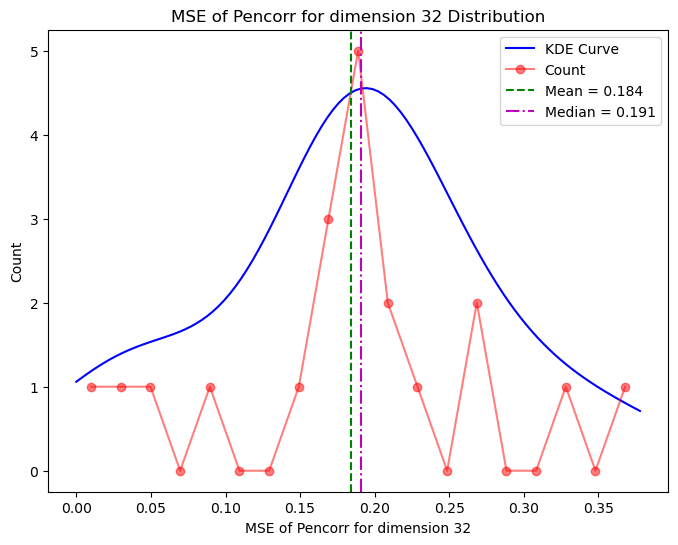

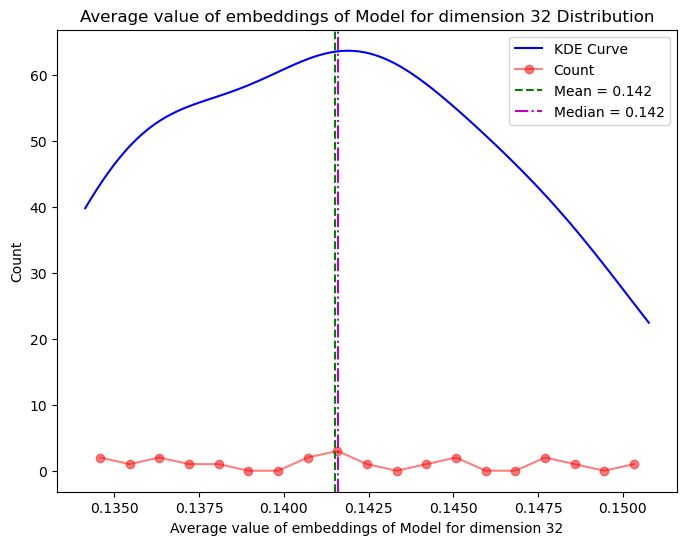

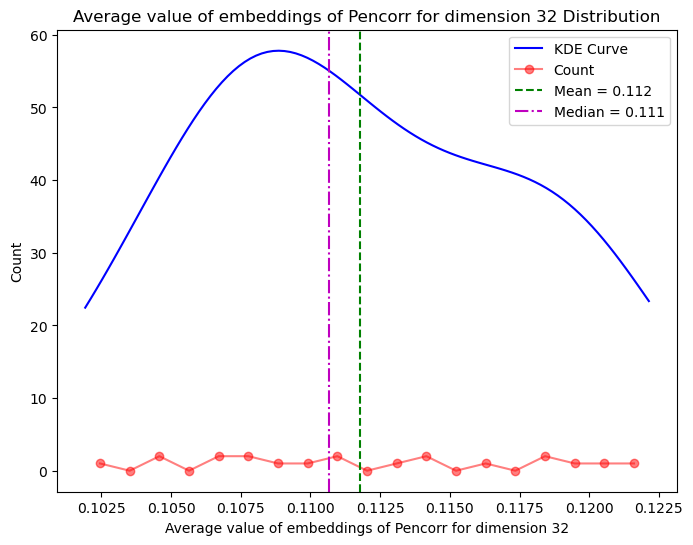

For dimension 64
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


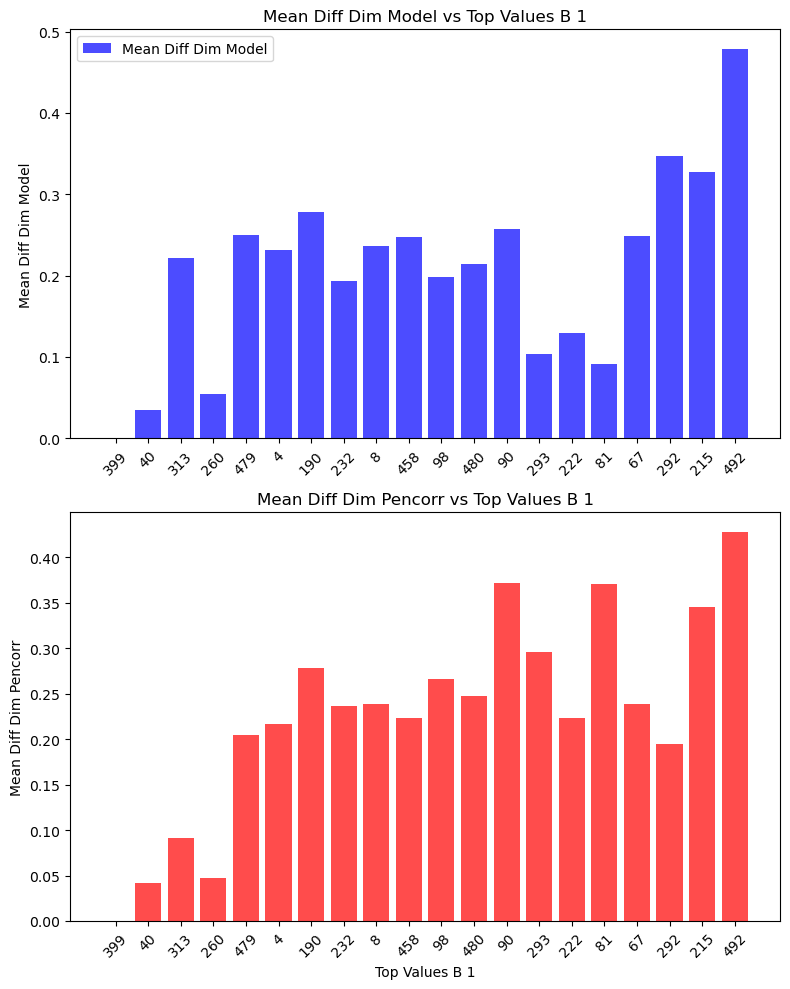

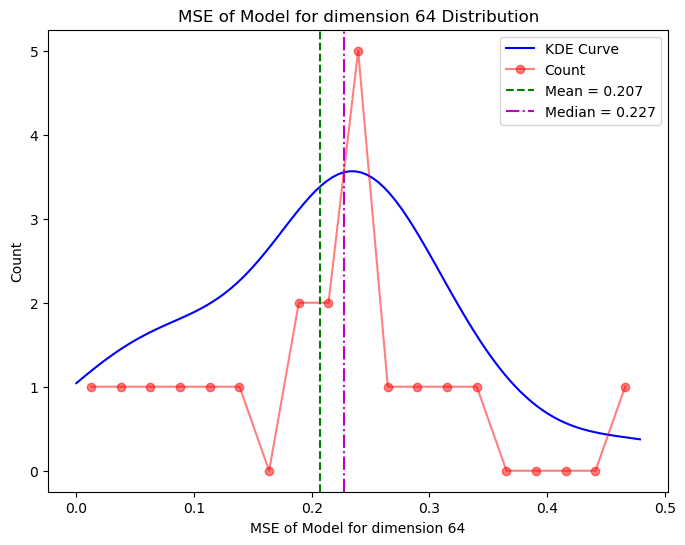

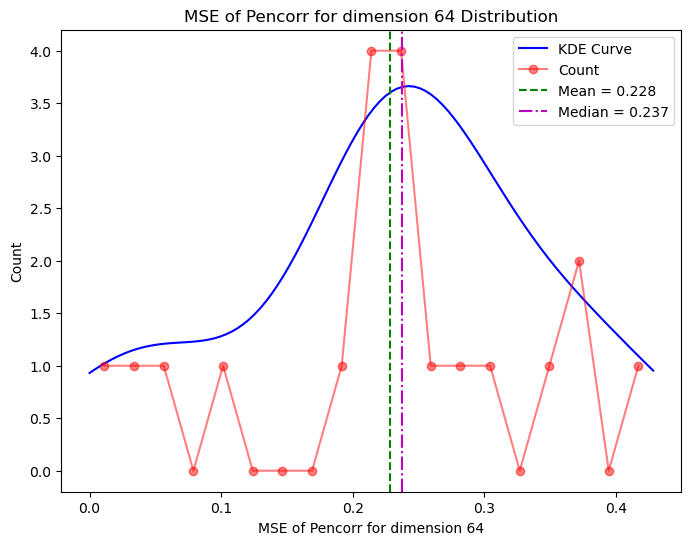

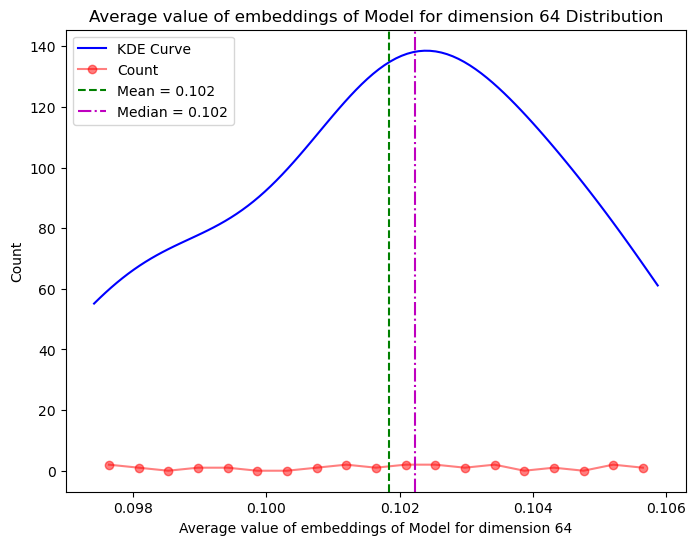

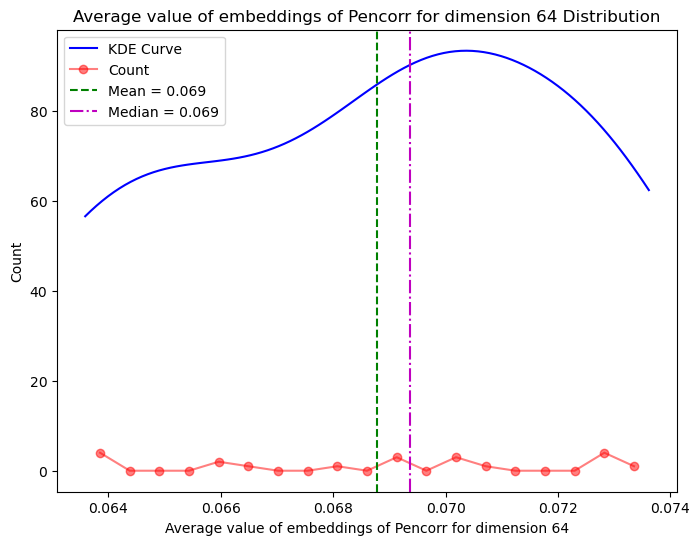

For dimension 128
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


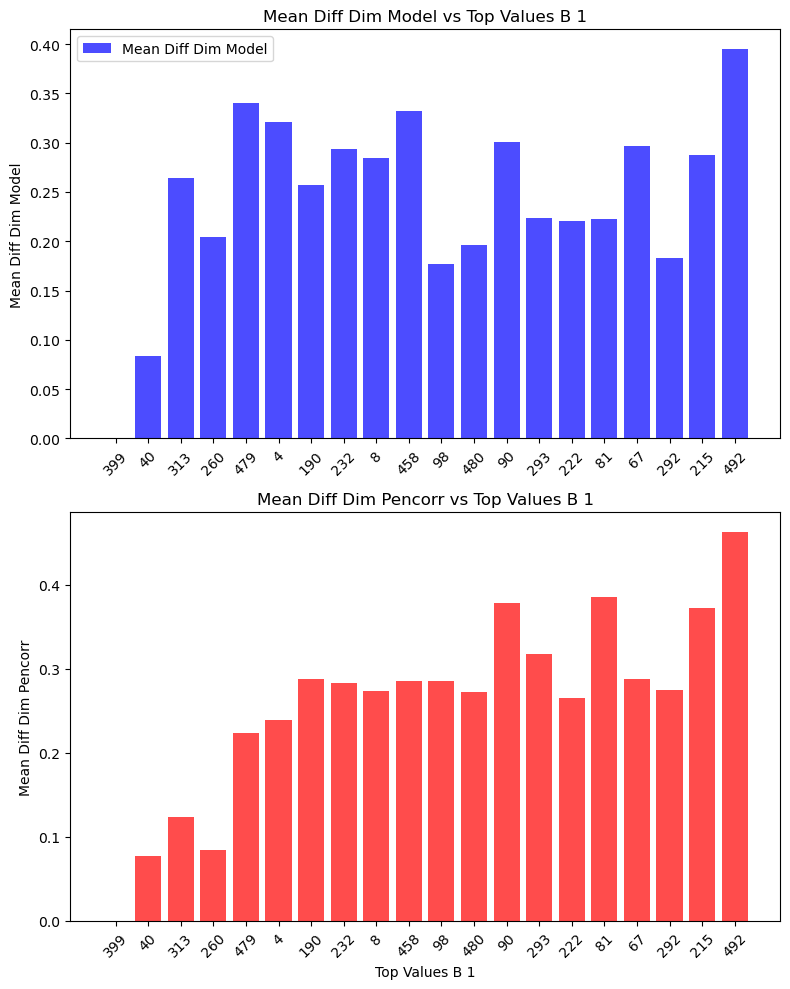

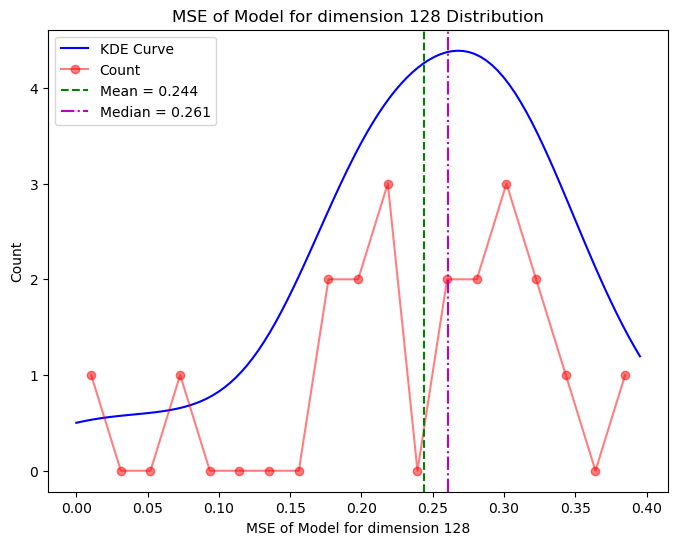

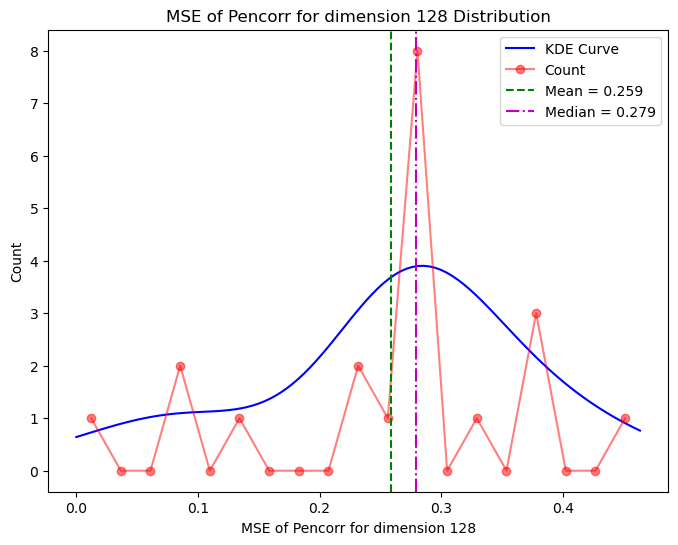

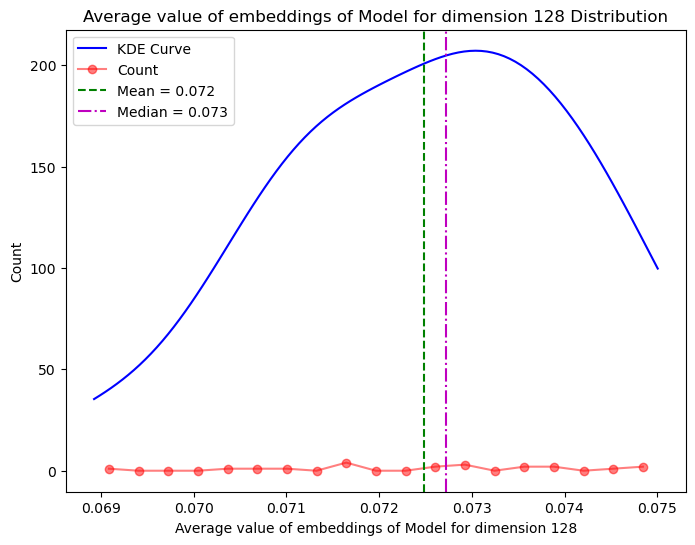

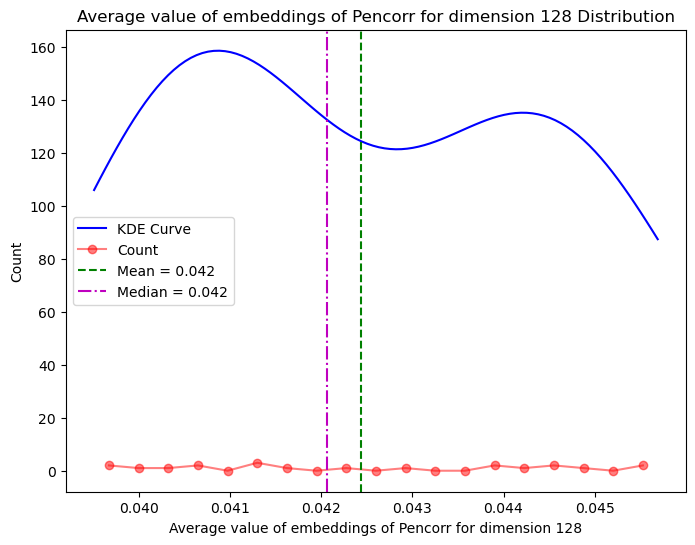

For dimension 256
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


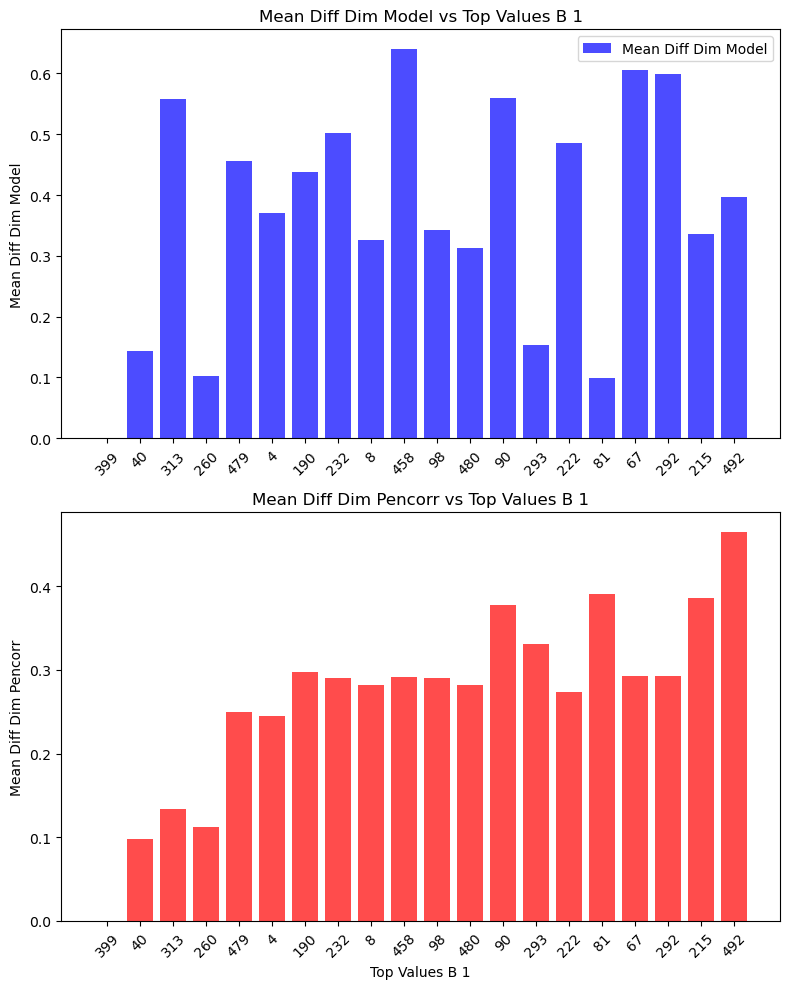

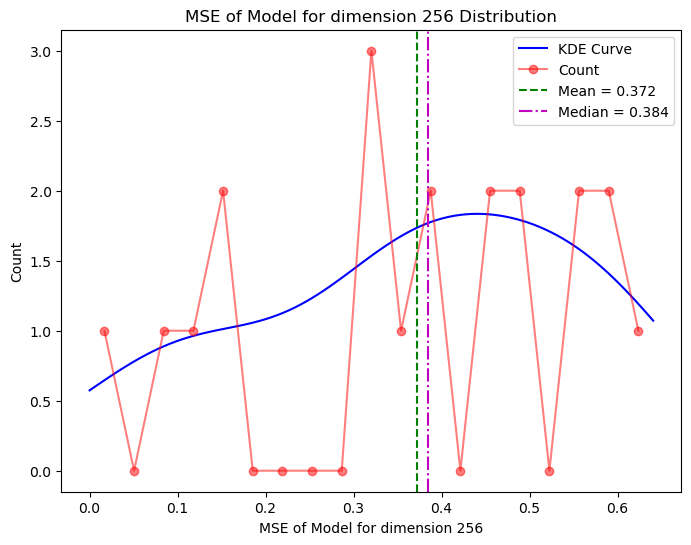

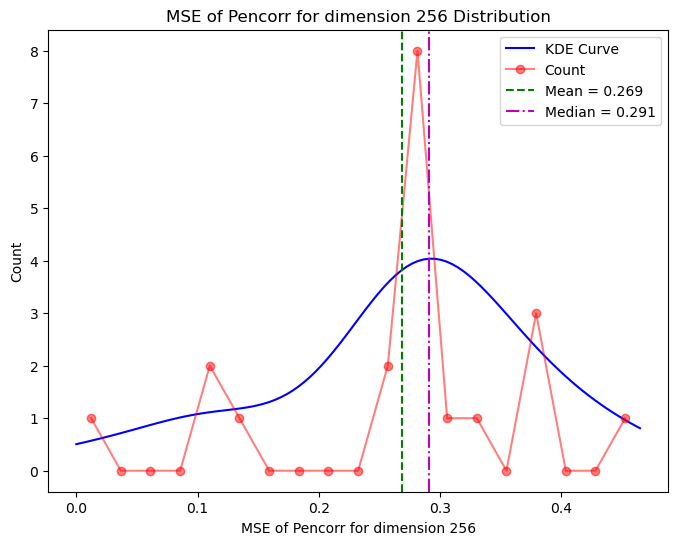

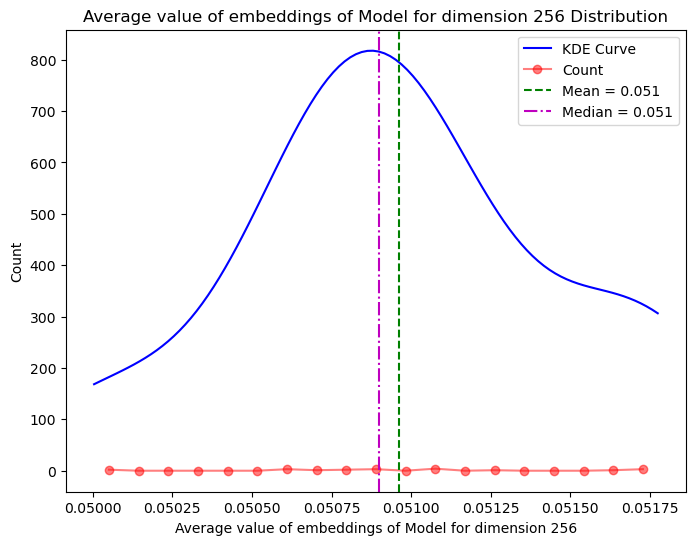

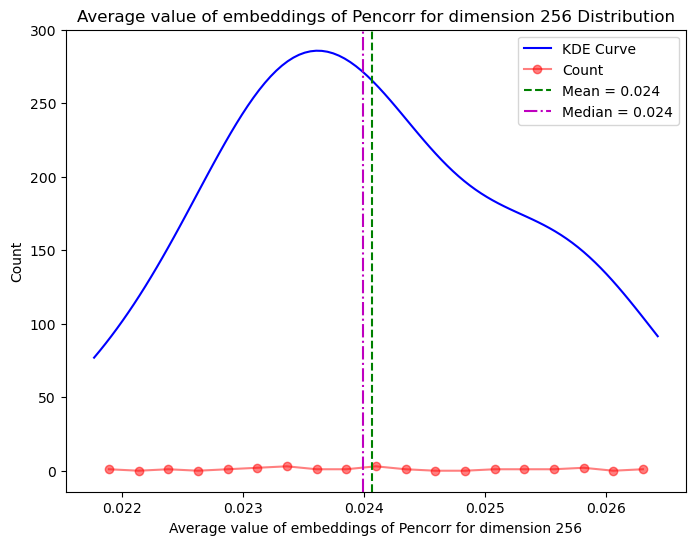

In [11]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

### Visualisation of original vector embeddings of different images across dimensions -- Metric 4

For dimension 32


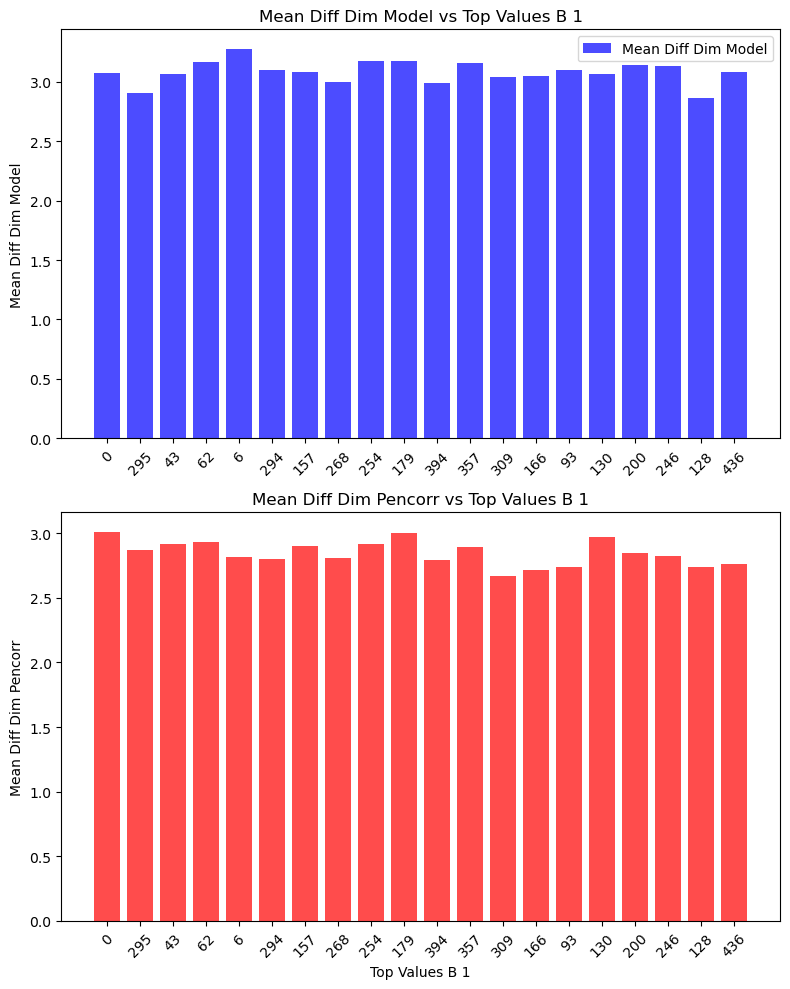

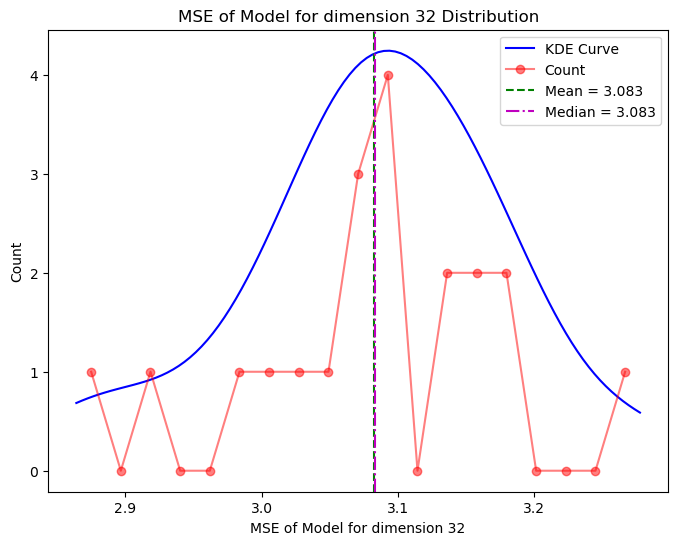

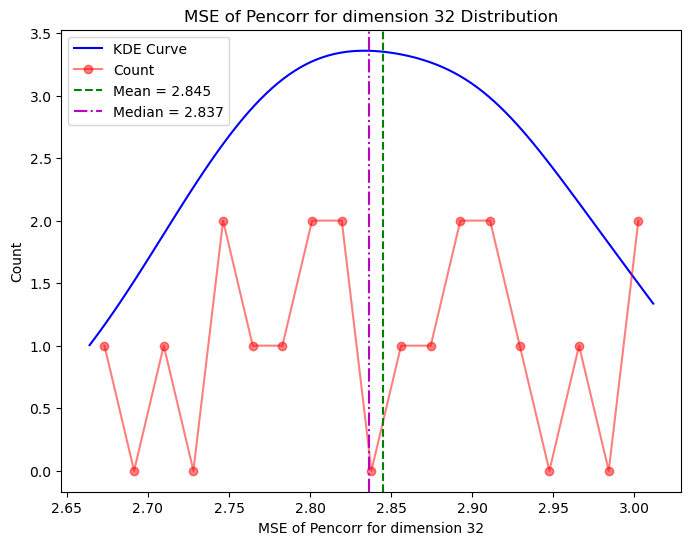

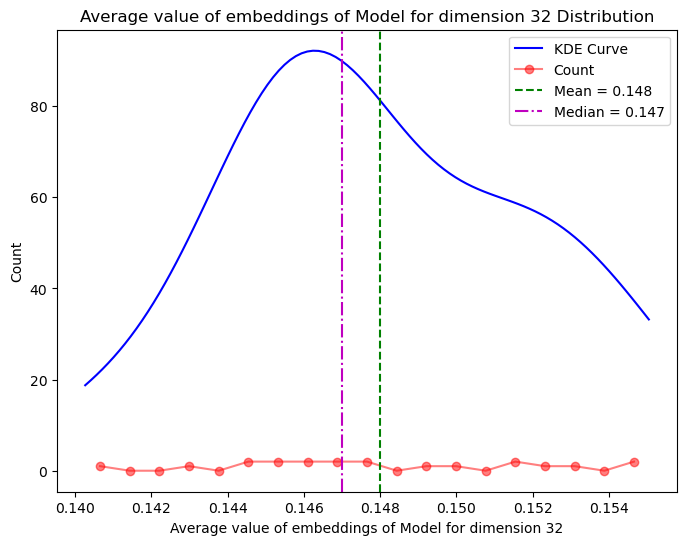

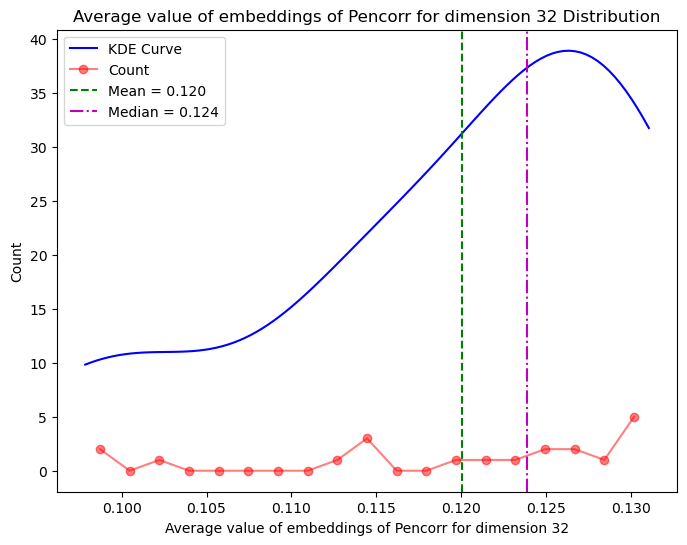

For dimension 64


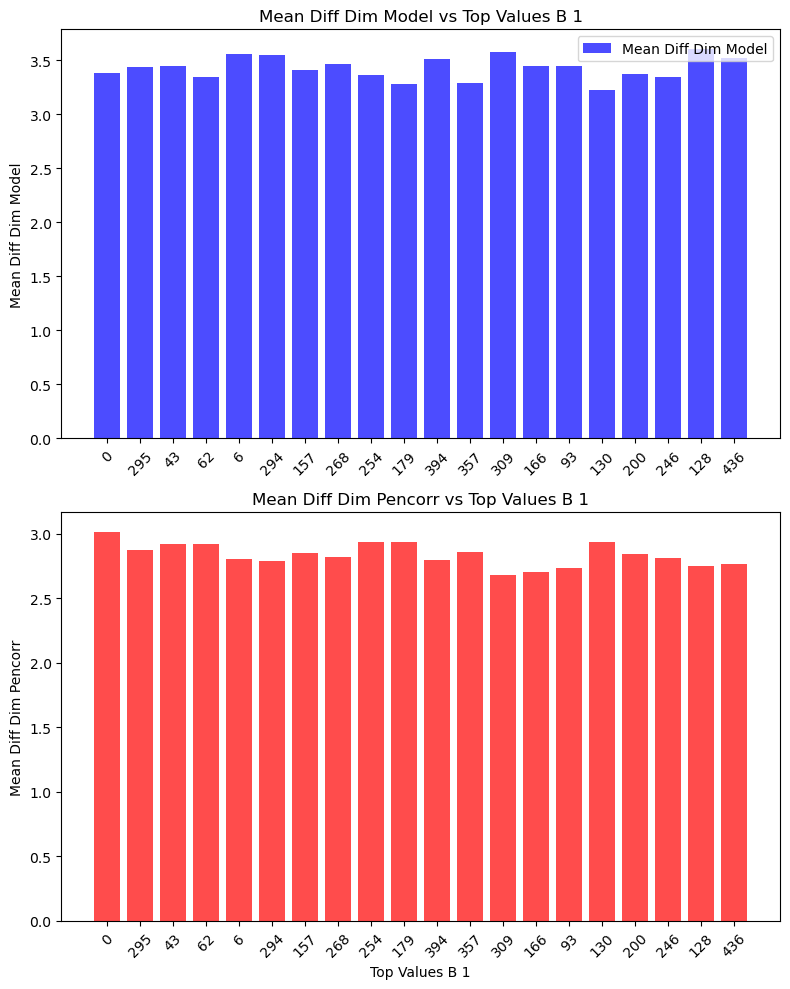

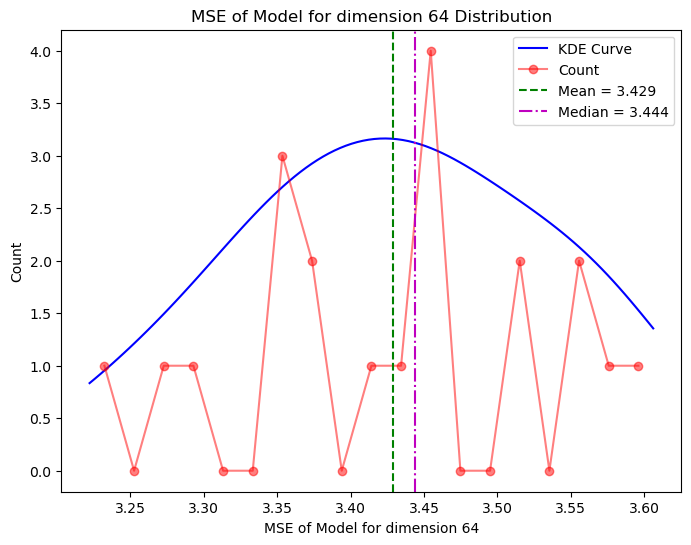

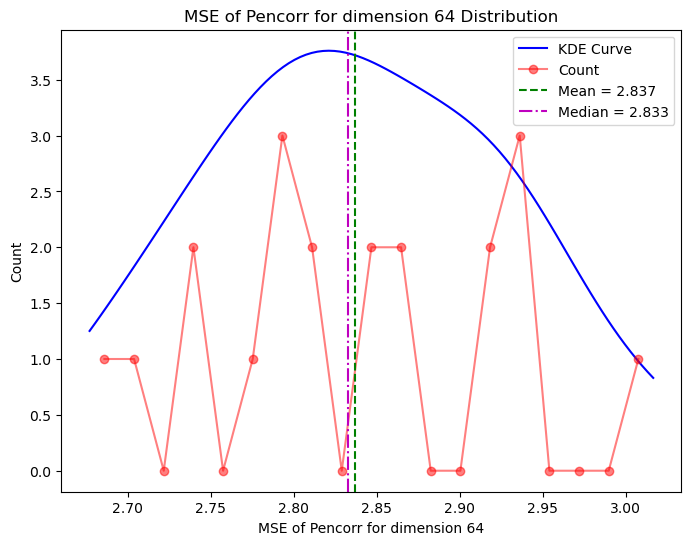

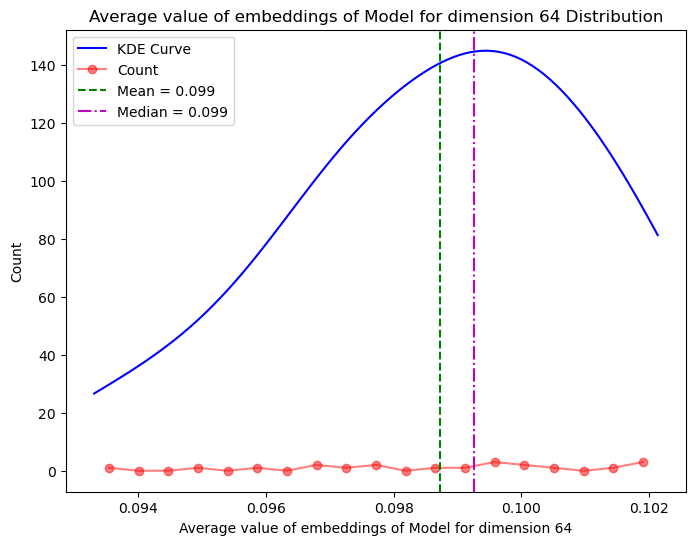

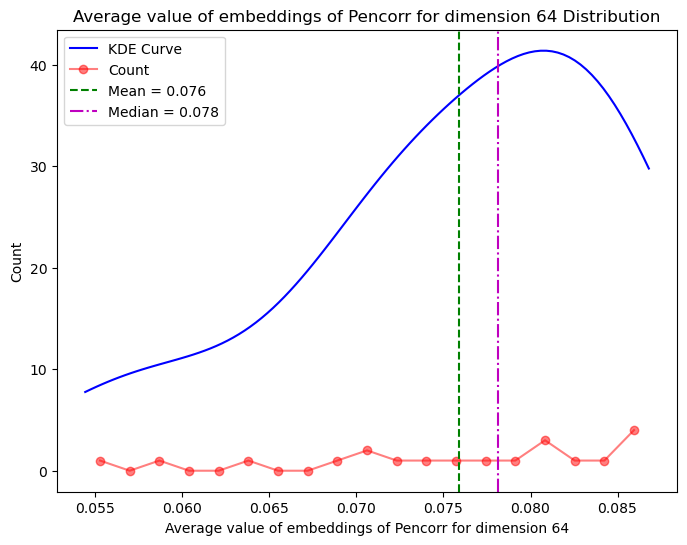

For dimension 128


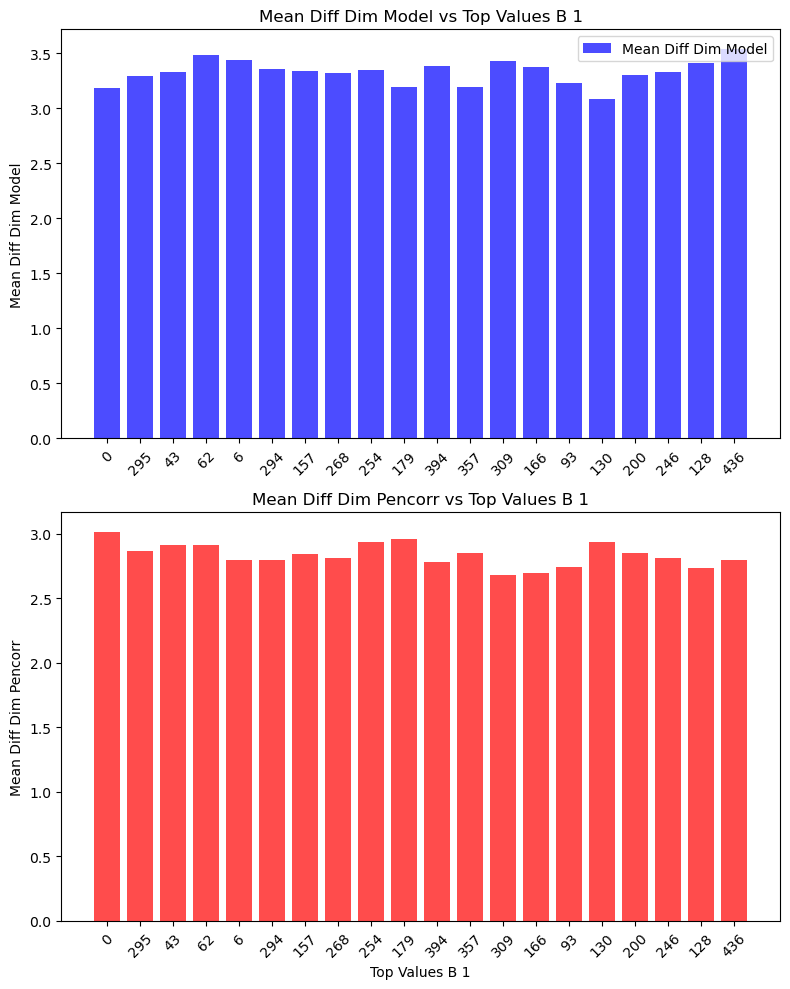

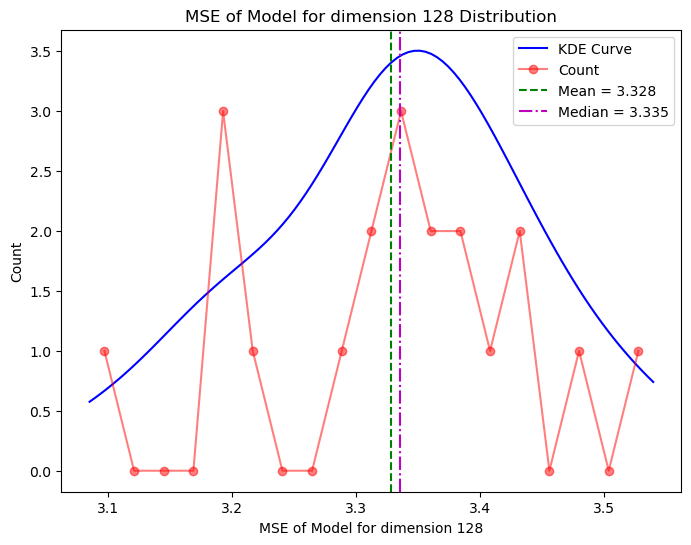

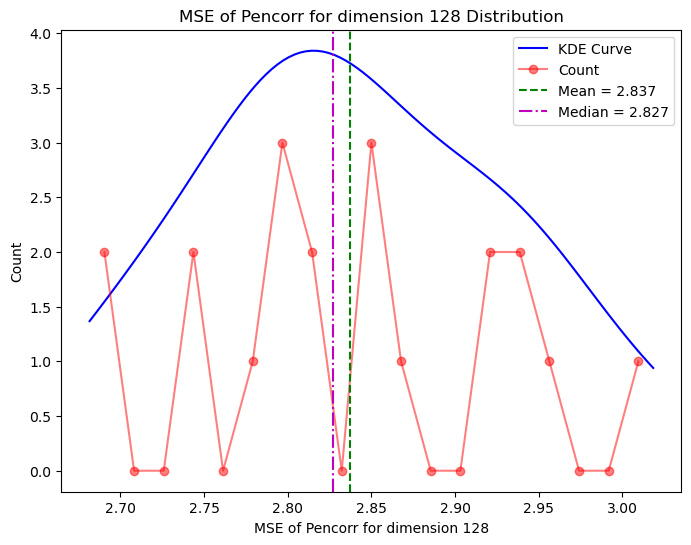

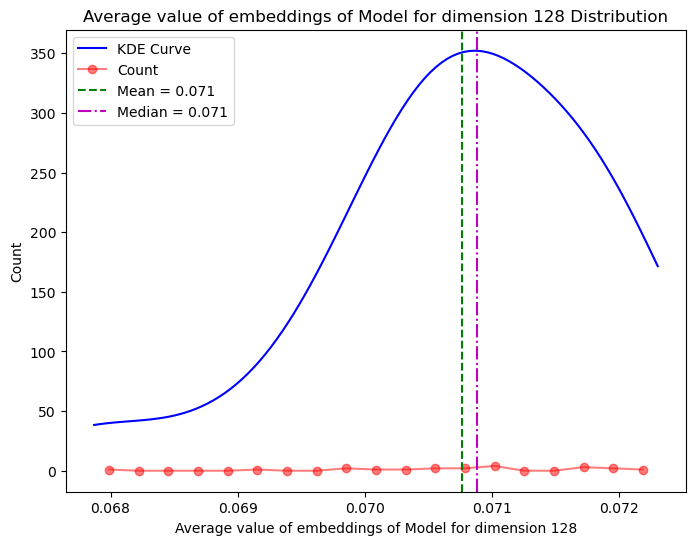

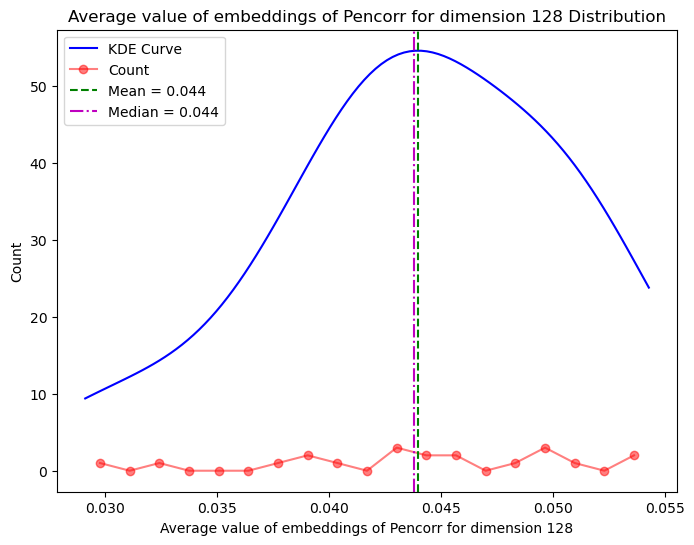

For dimension 256


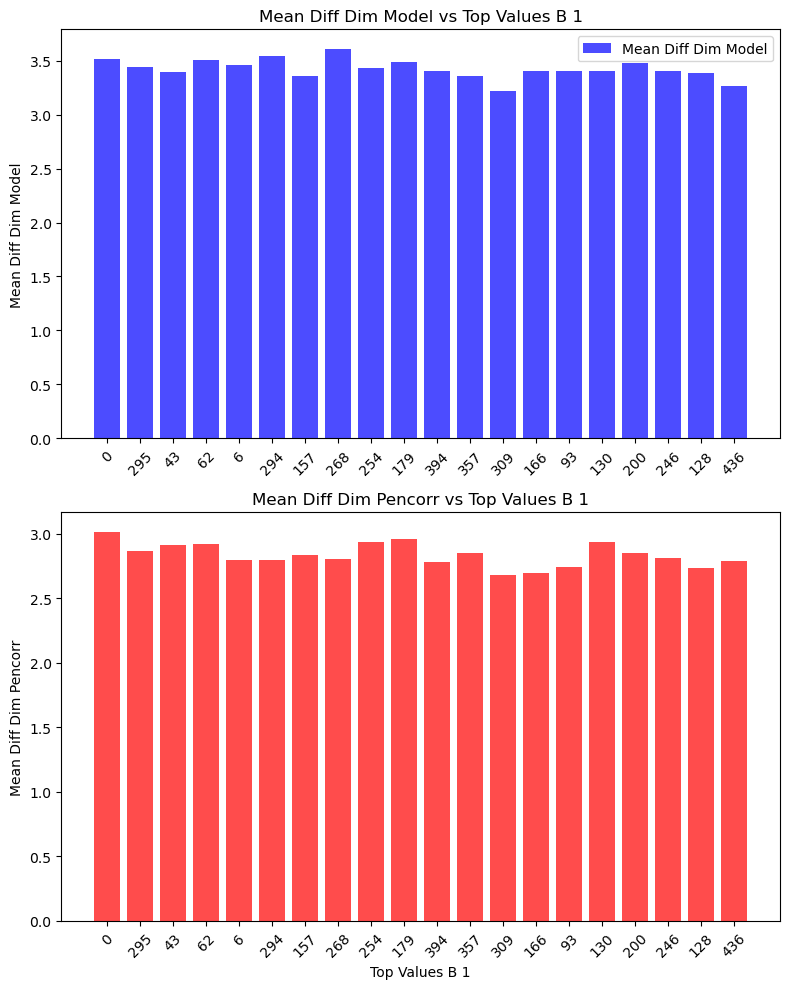

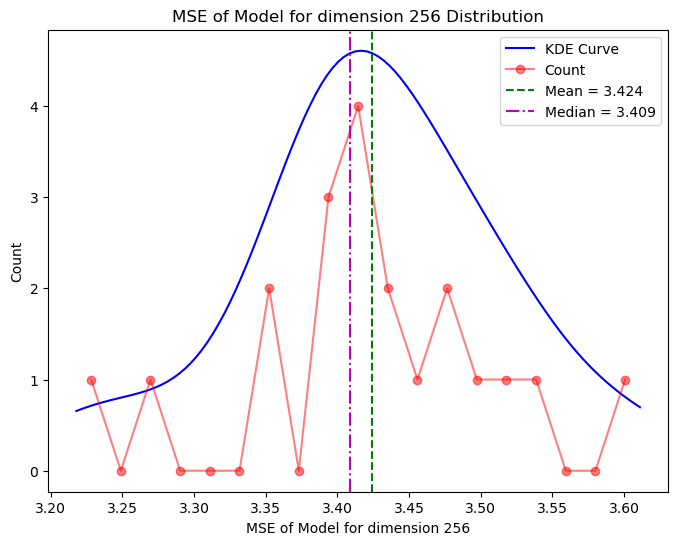

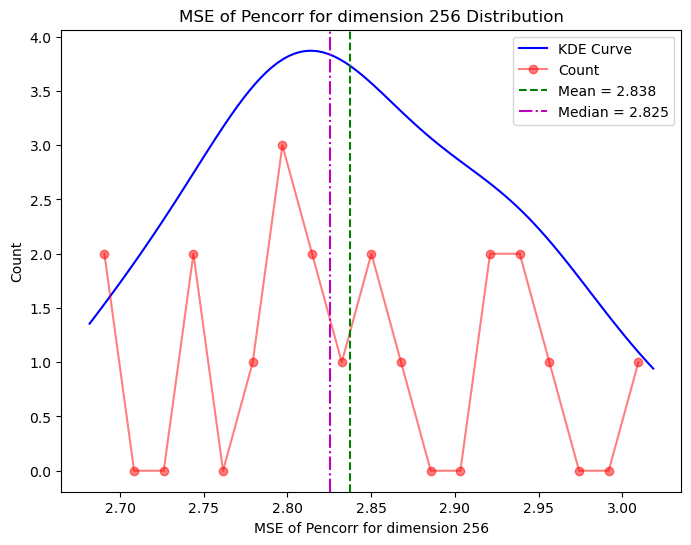

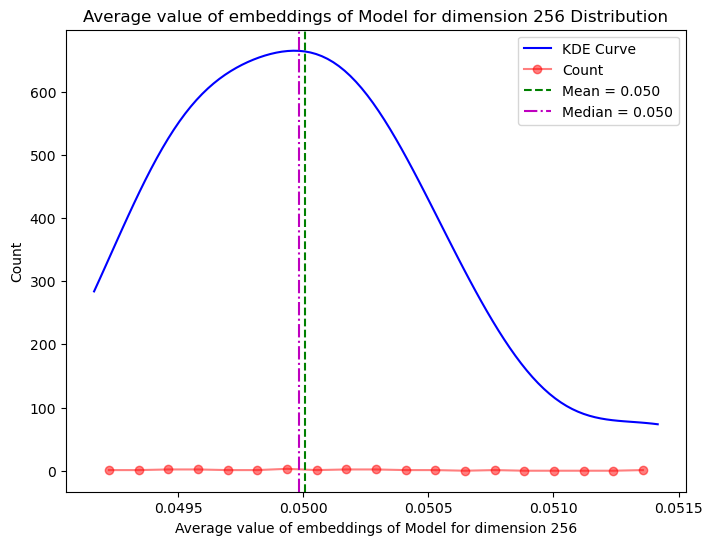

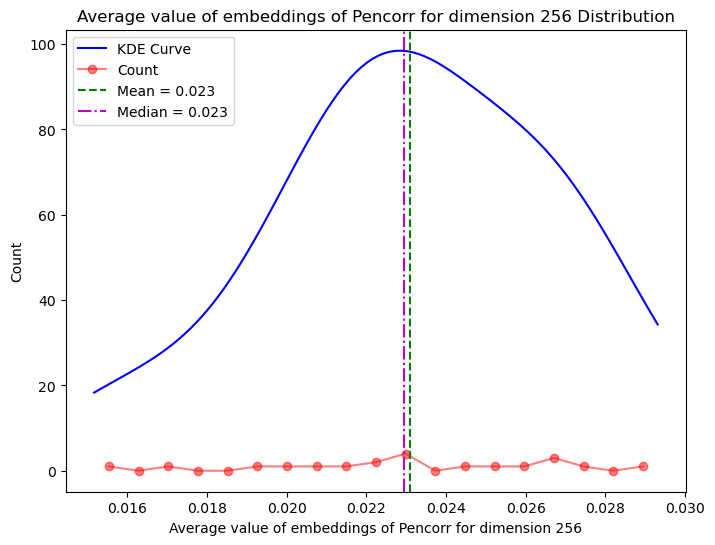

In [12]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

# Visualiation and Calculation across dataset, across dimensions

## Metric 1 & 2: Loss and K-Score
### Visualisation of loss and k-score across dataset across dimensions

For dimension 64

NCC Interval		Average Loss
-0.1-0.0		0.1303 (19957 samples)
-0.2--0.1		0.1540 (20720 samples)
-0.3--0.2		0.1782 (20756 samples)
-0.4--0.3		0.2114 (20845 samples)
-0.5--0.4		0.2530 (19690 samples)
-0.6--0.5		0.3021 (19962 samples)
-0.7--0.6		0.3653 (18633 samples)
-0.8--0.7		0.4591 (13961 samples)
-0.9--0.8		0.5726 (3740 samples)
-1.0--0.9		0.8247 (64 samples)
0.0-0.1		0.1139 (19588 samples)
0.1-0.2		0.1026 (18435 samples)
0.2-0.3		0.0944 (15657 samples)
0.3-0.4		0.0909 (12858 samples)
0.4-0.5		0.0905 (9942 samples)
0.5-0.6		0.0944 (6984 samples)
0.6-0.7		0.1057 (4330 samples)
0.7-0.8		0.1161 (2332 samples)
0.8-0.9		0.1048 (914 samples)
0.9-1.0		0.0131 (632 samples)


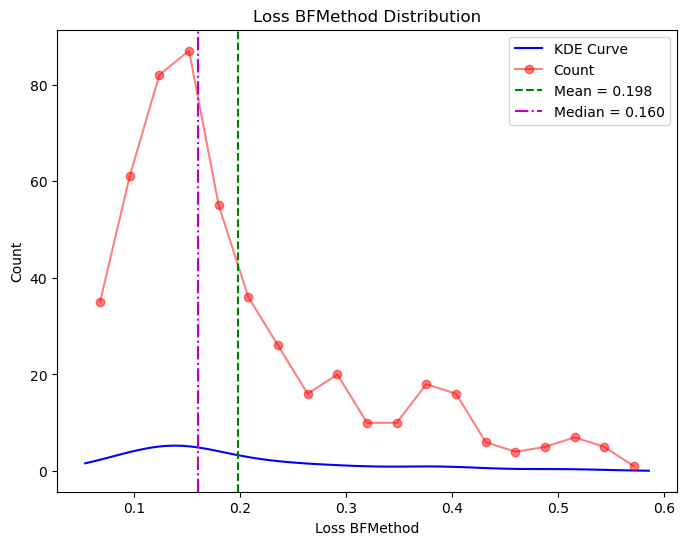

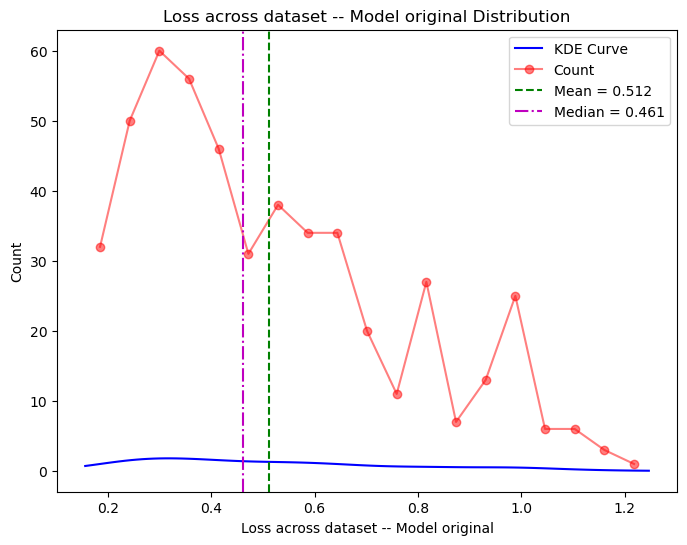

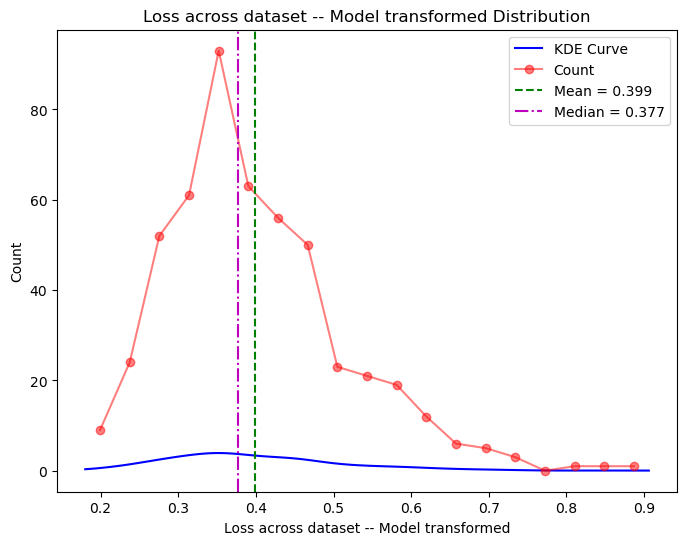

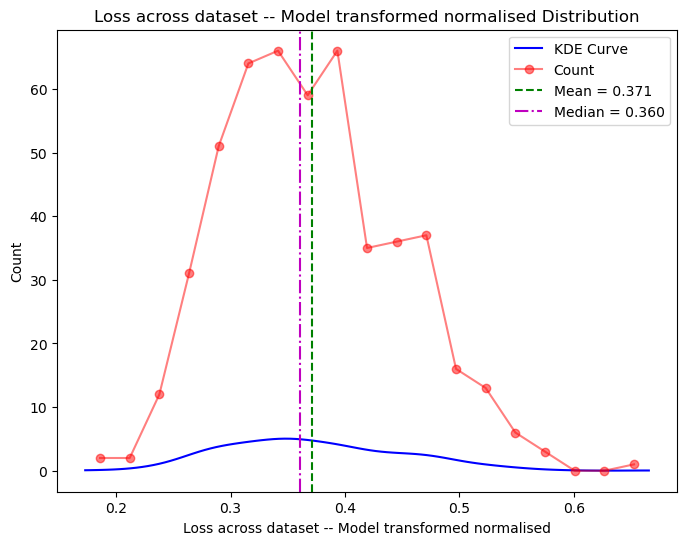

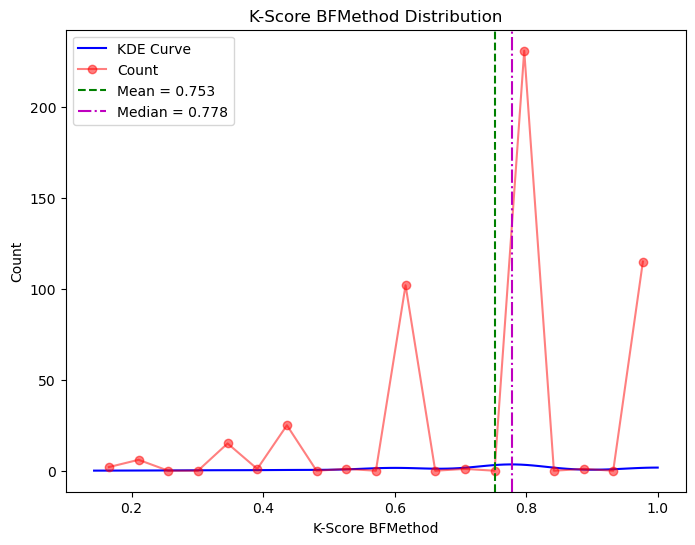

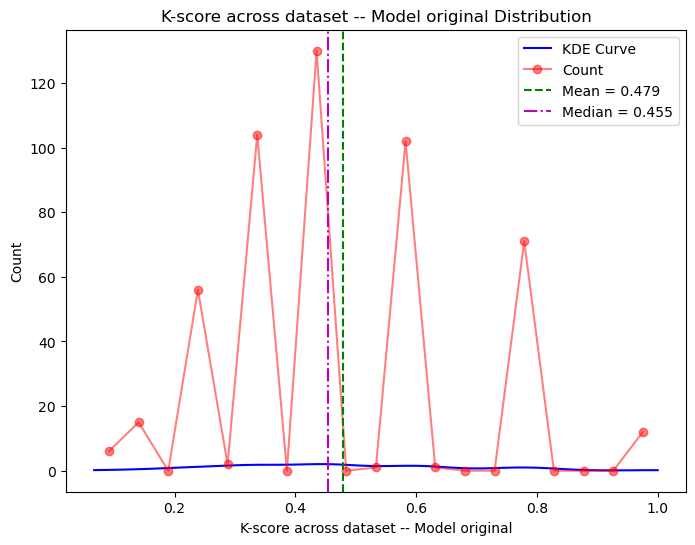

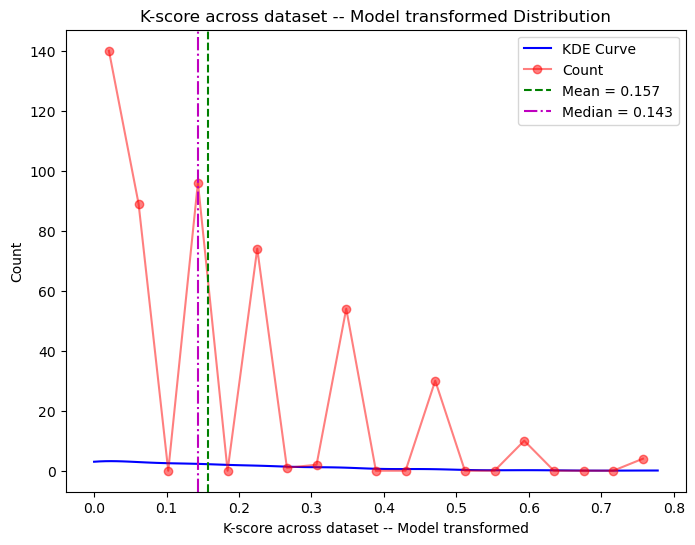

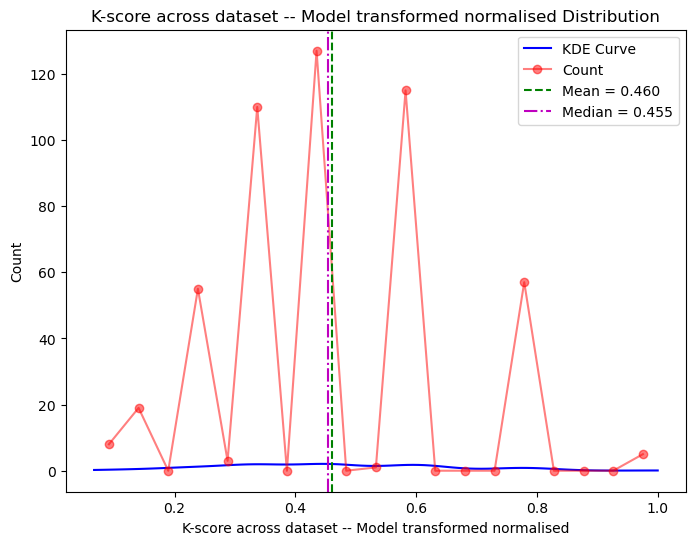

In [4]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
model_directory = "model"
dimensions = [64]
losses_transformed_normalised = []
losses_transformed = []
losses_original = []
kscores_transformed_normalised = []
kscores_transformed = []
kscores_original = []
losses_BFMethod = []
kscores_BFMethod = []

input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions: 
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6_aps_CBAM_dropout(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer5_SimpleCNN6_aps_CBAM_dropout.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()

    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

    kscore_transformed_normalised = []
    kscore_transformed = []
    kscore_original = []
    
    loss_original = []
    loss_transformed = []
    loss_transformed_normalised = []
    
    for i in range(num):
        vectorb = imgcalc.get_vectorb(i, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        #since after transformation, its not a unit vector
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            #since after transformation, its not a unit vector
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())

            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)

            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])

            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
            
    kscore_BFMethod, loss_BFMethod, _ = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)
    
    imgplt.plot_score_distribution(loss_BFMethod, "Loss BFMethod")
    imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
    imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
    imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
    imgplt.plot_score_distribution(kscore_BFMethod, "K-Score BFMethod")
    imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
    imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
    imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")
    
    losses_transformed_normalised.append(np.mean(loss_transformed_normalised))
    losses_transformed.append(np.mean(loss_transformed))
    losses_original.append(np.mean(loss_original))
    losses_BFMethod.append(np.mean(loss_BFMethod))
    kscores_transformed_normalised.append(np.mean(kscore_transformed_normalised))
    kscores_transformed.append(np.mean(kscore_transformed))
    kscores_original.append(np.mean(kscore_original))
    kscores_BFMethod.append(np.mean(kscore_BFMethod))
    
    #0.323 CNN6_CBAM_dropout_altLPS
    #0.444 CNN6_CBAM_dropout

In [22]:
print(f"BFMethod: Loss and Kscores")
print("Kscores: ",kscores_BFMethod, np.argmax(kscores_BFMethod))
print("Losses: ",losses_BFMethod, np.argmin(losses_BFMethod))

print(f"\nOriginal Model: Loss and Kscores")
print("Kscores: ",kscores_original, np.argmax(kscores_original))
print("Losses: ",losses_original, np.argmin(losses_original))

print(f"\nTransformed Model: Loss and Kscores")
print("Kscores: ",kscores_transformed, np.argmax(kscores_transformed))
print("Losses: ",losses_transformed, np.argmin(losses_transformed))

print(f"\nTransformed Normalized Model: Loss and Kscores")
print("Kscores: ",kscores_transformed_normalised, np.argmax(kscores_transformed_normalised))
print("Losses: ",losses_transformed_normalised, np.argmin(losses_transformed_normalised))

BFMethod: Loss and Kscores
Kscores:  [0.48807012676865613, 0.5661929958929959, 0.6153775002775003, 0.665639749139749, 0.7017286269286269, 0.7058821622821623] 5
Losses:  [0.16224564440197656, 0.11285151464604015, 0.0909312541117238, 0.08234213345520815, 0.07960513896550532, 0.0794685682672371] 5

Original Model: Loss and Kscores
Kscores:  [0.19285609488550665, 0.2085311223090635, 0.22664903527844707, 0.21940024436347966, 0.23490270073064193, 0.2643298064680418] 5
Losses:  [0.28843166851238417, 0.28152482781816757, 0.27470317693781177, 0.26935968095536755, 0.2647041436888548, 0.25731962604128955] 5

Transformed Model: Loss and Kscores
Kscores:  [0.2825366654587243, 0.36081191945309593, 0.36297594399064986, 0.27709591372679615, 0.2397406614627203, 0.24916681341534283] 2
Losses:  [0.2535804079199347, 0.25257266990584687, 0.2532453739940636, 0.2539364997031902, 0.25460270246261474, 0.25368550645012733] 1

Transformed Normalized Model: Loss and Kscores
Kscores:  [0.42996665850489374, 0.48453

## Metric 3: Relative Squared Difference between vector embeddings
### Visualisation of Relative Squared Difference between vector embeddings, of original and transformed model using Orthogonal Procrustes, and Pencorr embeddings across dataset across dimensions


MSE between vector embeddings of dimension 8 for Pencorr (A) and Models:


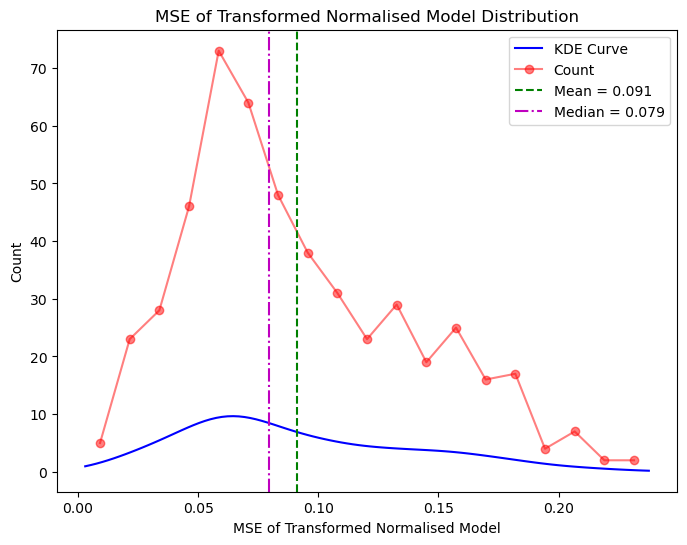

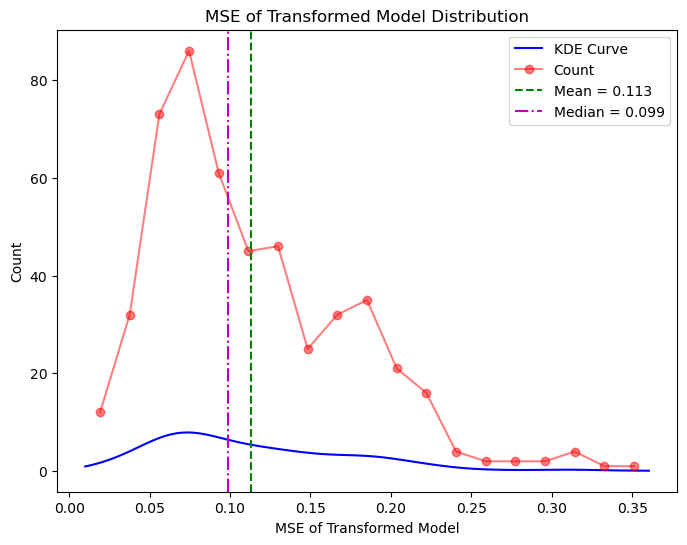

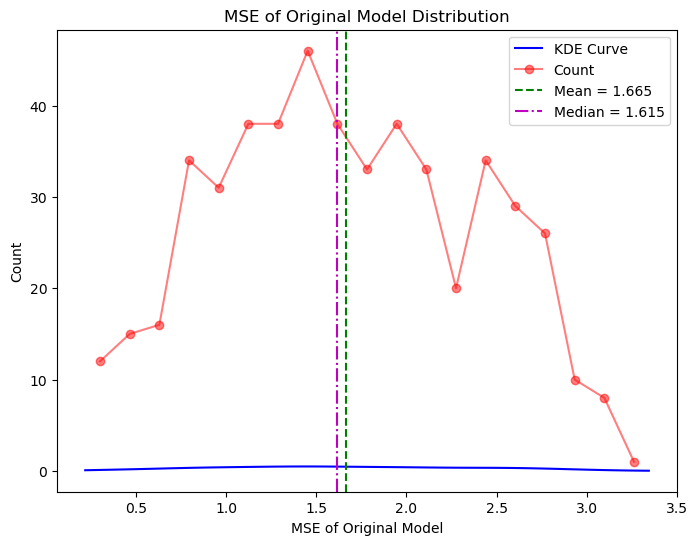


MSE between vector embeddings of dimension 16 for Pencorr (A) and Models:


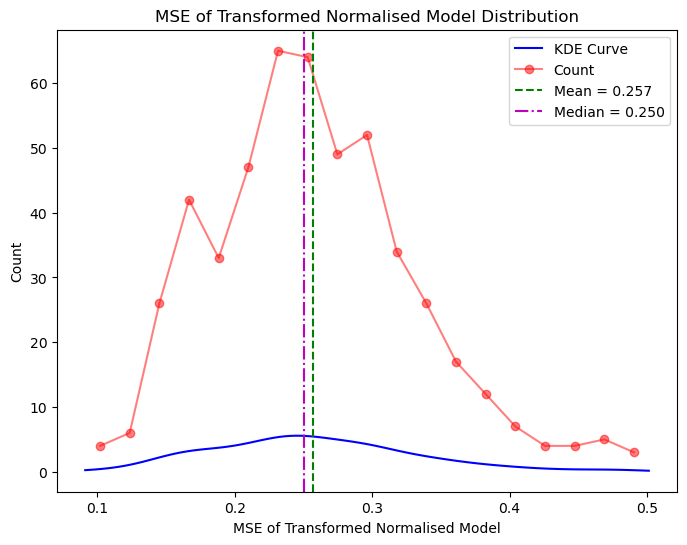

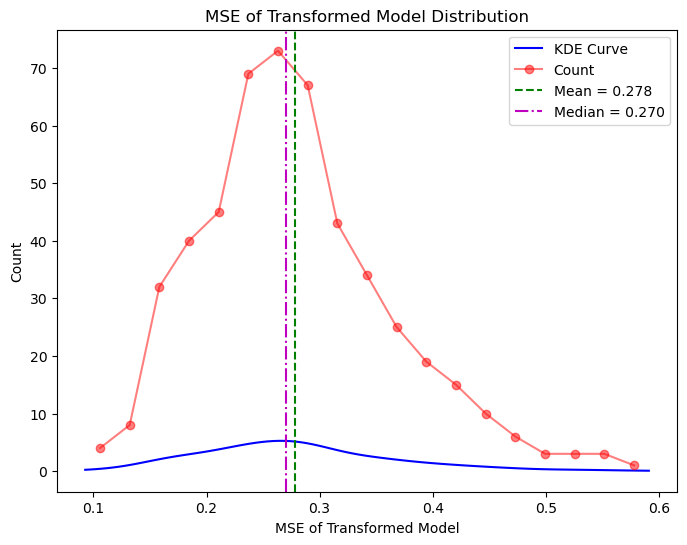

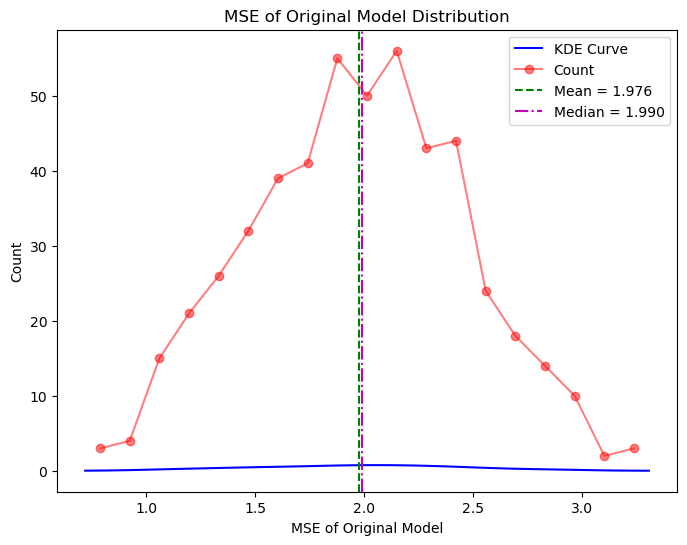


MSE between vector embeddings of dimension 32 for Pencorr (A) and Models:


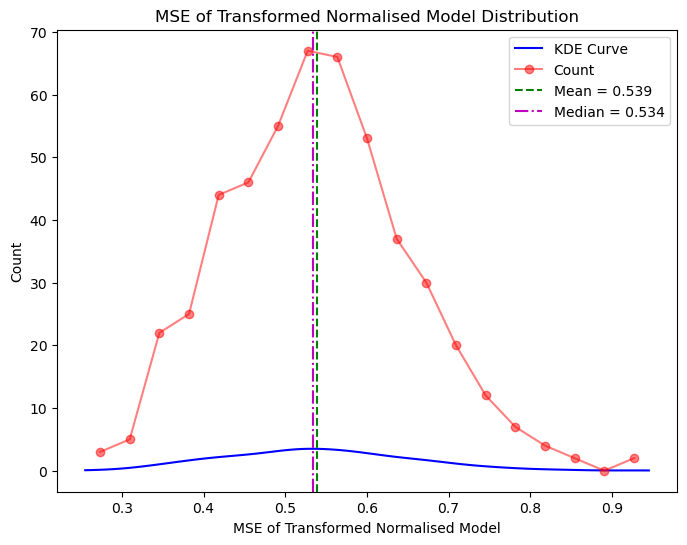

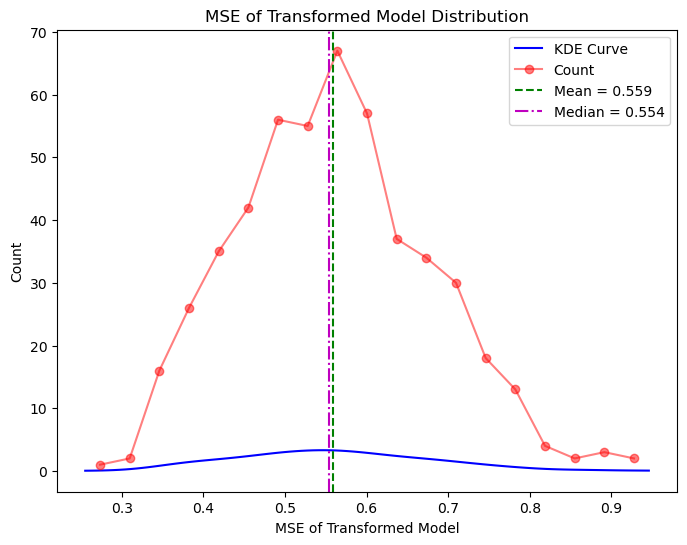

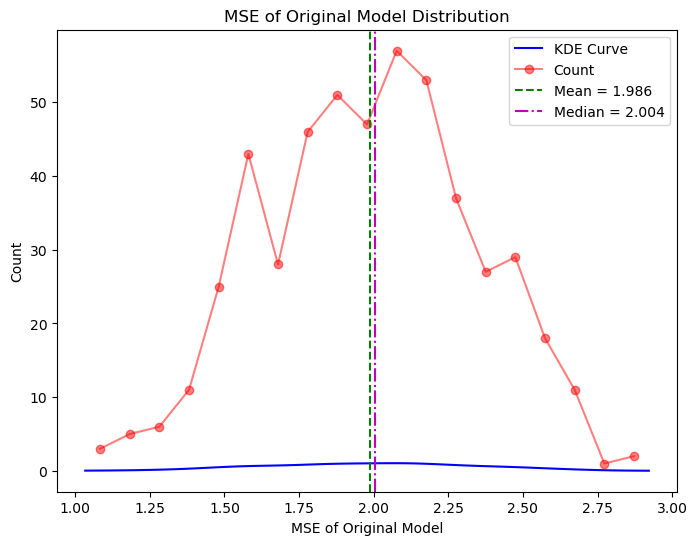


MSE between vector embeddings of dimension 64 for Pencorr (A) and Models:


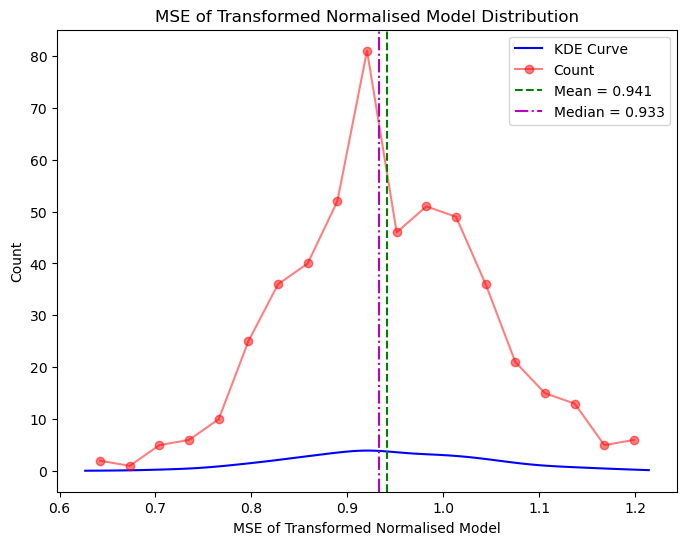

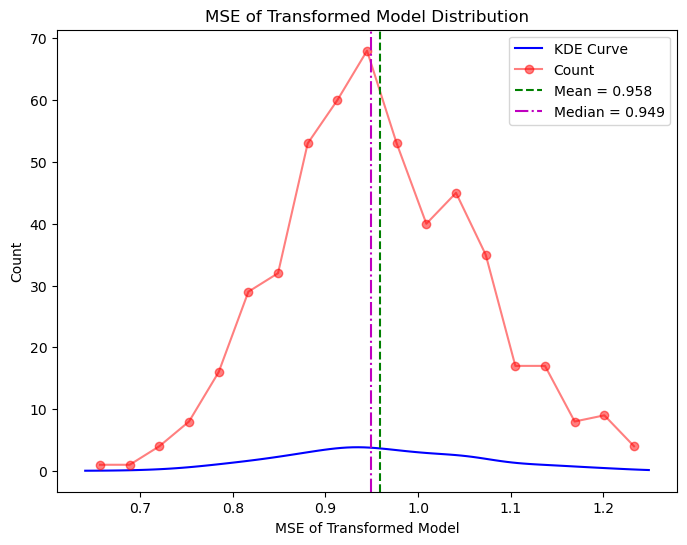

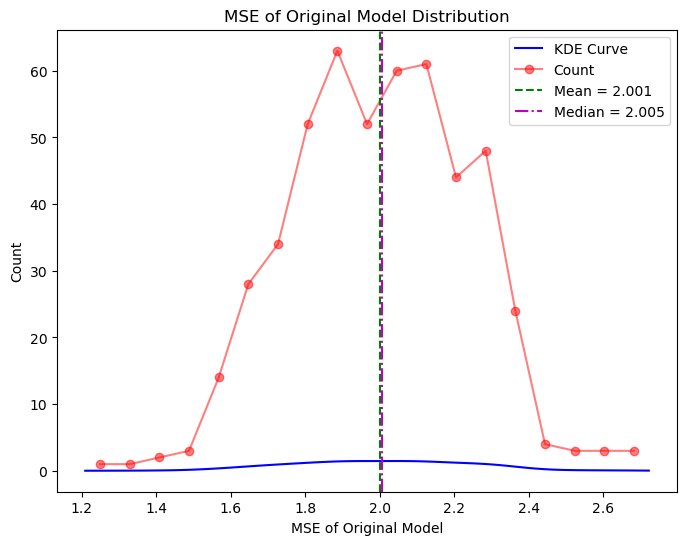


MSE between vector embeddings of dimension 128 for Pencorr (A) and Models:


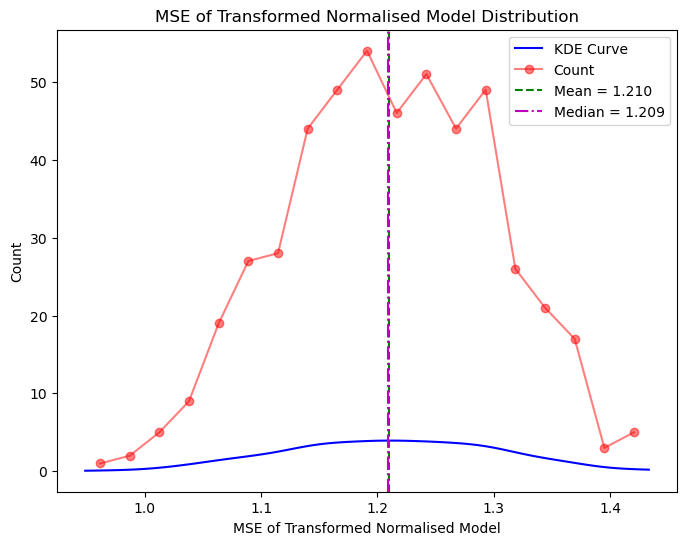

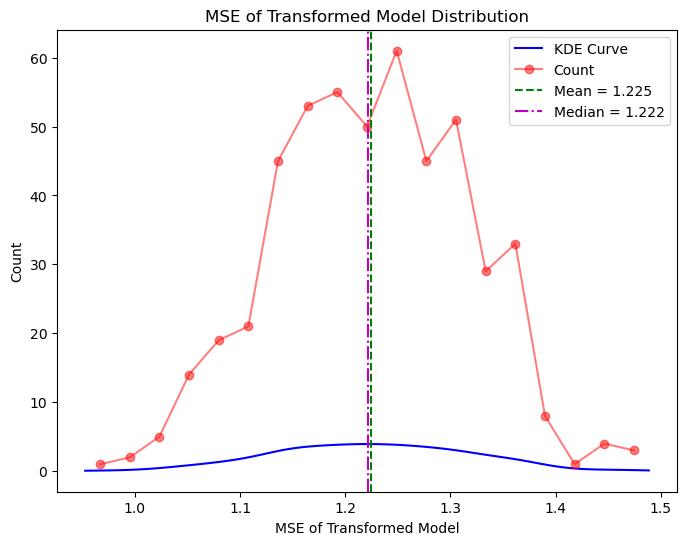

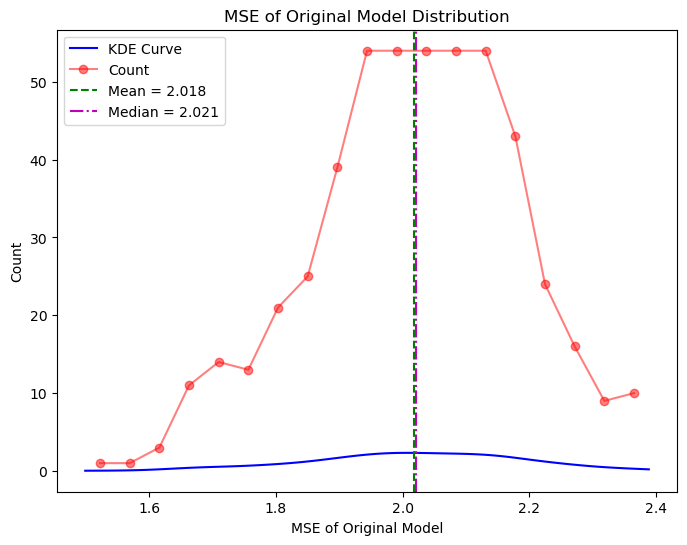


MSE between vector embeddings of dimension 256 for Pencorr (A) and Models:


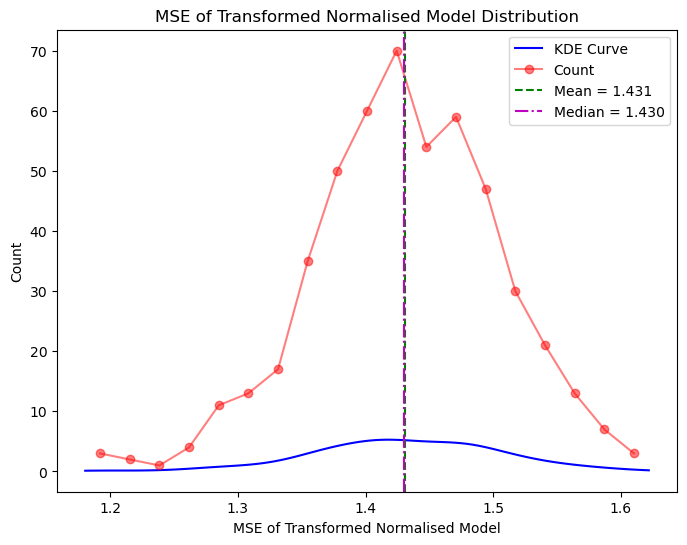

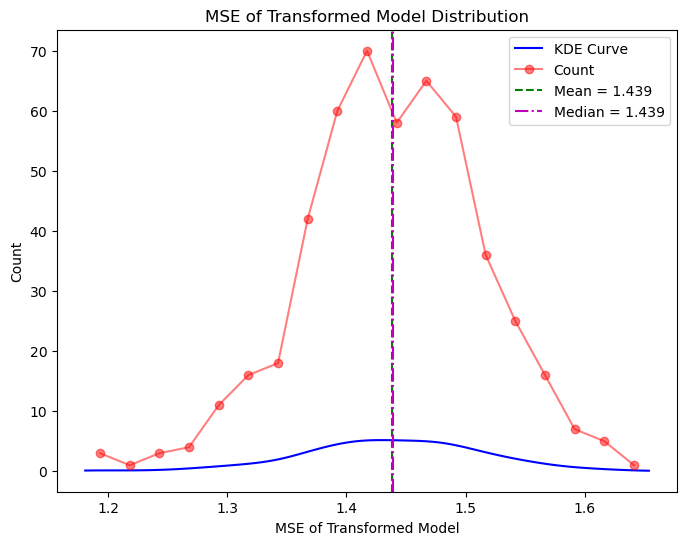

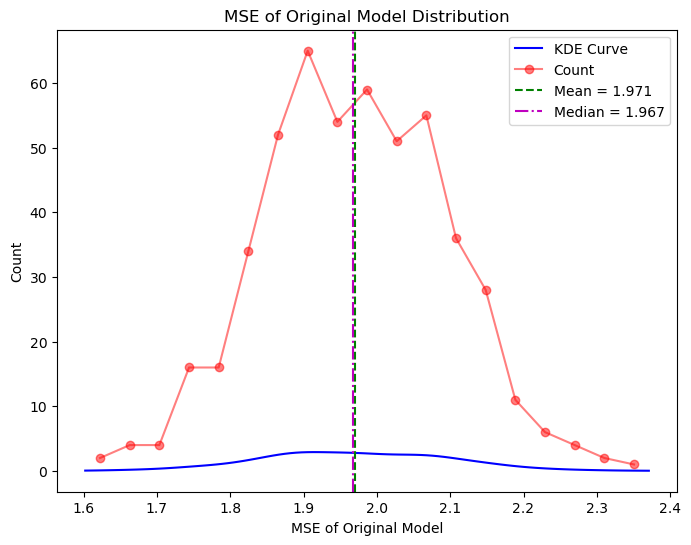

In [13]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed_normalised = []
MSD_transformed = []
MSD_original = []
dimensions = [32, 64, 128, 256]    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    # find a fair way to compare across the dimensions,
        # maybe can experiment with the different angles \
    MSE_transformed_normalised = []
    MSE_transformed = []
    MSE_original = []
    
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Models:")   
    for i in range(num):
        normalized_embedding = (model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())).detach().cpu().numpy()
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], normalized_embedding)
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed_normalised.append(mean_squared_difference)
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_transformed_normalised.append(np.mean(MSE_transformed_normalised))                                              
    MSD_transformed.append(np.mean(MSE_transformed))
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_transformed_normalised, f"MSE of Transformed Normalised Model")                                              
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [23]:
print("RSD Original Model: ", MSD_original, np.argmin(MSD_original))
print("RSD Transformed Model: ", MSD_transformed, np.argmin(MSD_transformed))
print("RSD Transformed Normalised Model: ", MSD_transformed_normalised, np.argmin(MSD_transformed_normalised))

RSD Original Model:  [1.6648418972950834, 1.9758035357203754, 1.9861888843901783, 2.0006841799924024, 2.018331309203943, 1.9705460720611605] 0
RSD Transformed Model:  [0.11303834240937241, 0.2784498244449845, 0.5589784446656207, 0.9584591243131244, 1.2247190200288256, 1.4385428187120581] 0
RSD Transformed Normalised Model:  [0.09093547311118738, 0.2571486421523014, 0.5389498982689043, 0.9410276709023642, 1.2103203070296882, 1.4311958856552154] 0


## Metric 4: F1 Score
### Calculation of F1 Score across dimension using original vector embeddings and Pencorr embeddings

In [14]:
#For model method F1 score calculation per dimension K
dimensions = [16, 32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN3(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer2.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    #matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[j].detach().cpu().numpy())
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

For dimension 8
F1 Score: 7.0676 for dimension 8
For dimension 16
F1 Score: 5.5312 for dimension 16
For dimension 32
F1 Score: 5.8760 for dimension 32
For dimension 64
F1 Score: 5.7021 for dimension 64
For dimension 128
F1 Score: 4.9990 for dimension 128
For dimension 256
F1 Score: 5.6635 for dimension 256


In [28]:
#For BFMEthod F1 score calculation per dimension K
dimensions = [16, 32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    # model = models.SimpleCNN3(dimensions=dim, padding_mode='circular').to(device)
    # model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
    #                  f'best_model_{imageType}_{dim}d_convlayer2.pt'), weights_only=True, map_location=torch.device('cpu')))

    # model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    #model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,i], matrixA[:,top_1_index])
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], matrixA[:,j])
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

For dimension 8
F1 Score: 12.0827 for dimension 8
For dimension 16
F1 Score: 9.9133 for dimension 16
For dimension 32
F1 Score: 10.4140 for dimension 32
For dimension 64
F1 Score: 8.8687 for dimension 64
For dimension 128
F1 Score: 9.1213 for dimension 128
For dimension 256
F1 Score: 9.6791 for dimension 256


# Obtaining the optimal dimension using 4 different metrics above

In [29]:
from collections import Counter
dimensions = [32, 64, 128, 256]


metric1 = np.argmax(kscores_original)
metric2 = np.argmin(losses_original)
metric3A = np.argmin(MSD_original)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 256


### Using normalized embedding validation loss to determine optimal dimension.
#### Existing strategies for the selection of the embedding dimension rely on performance maximization in downstream tasks.

In [31]:
def find_optimal_dim(losses, eps=0.05):  
    """
    Finds the optimal dimension based on the embedding loss function.

    :param losses: Dictionary {dimension: loss value}
    :param eps: Threshold percentage (default 0.05)
    :return: The optimal dimension
    """
    L_inf = min(losses.values())

    for d in sorted(losses.keys()): 
        if L_inf == 0 or (losses[d] - L_inf) / L_inf <= eps:  
            return d  

    return max(losses.keys()) 

losses = {8: 0.17436, 16: 0.10059, 32: 0.08990, 64: 0.09155, 128: 0.09328, 256: 0.0636}
optimal_dim = find_optimal_dim(losses)
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 256


In [7]:
# -------------- for debugging -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 154
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than tolerance: 154

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.159